✓ PROJ_DATA set to: /opt/homebrew/share/proj
Reading London boundary data...
✓ Successfully read London data with fiona
London boundary CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
London area (km²): 1573.5055704485922

Reading CIS boundary data...
✓ Successfully read CIS data with fiona
CIS boundary CRS: EPSG:27700
Total CIS regions: 133

Reprojecting to common CRS...

Performing spatial overlay analysis...

CIS regions with >75% overlap with London:
CIS region J06000164: 97.50% ove

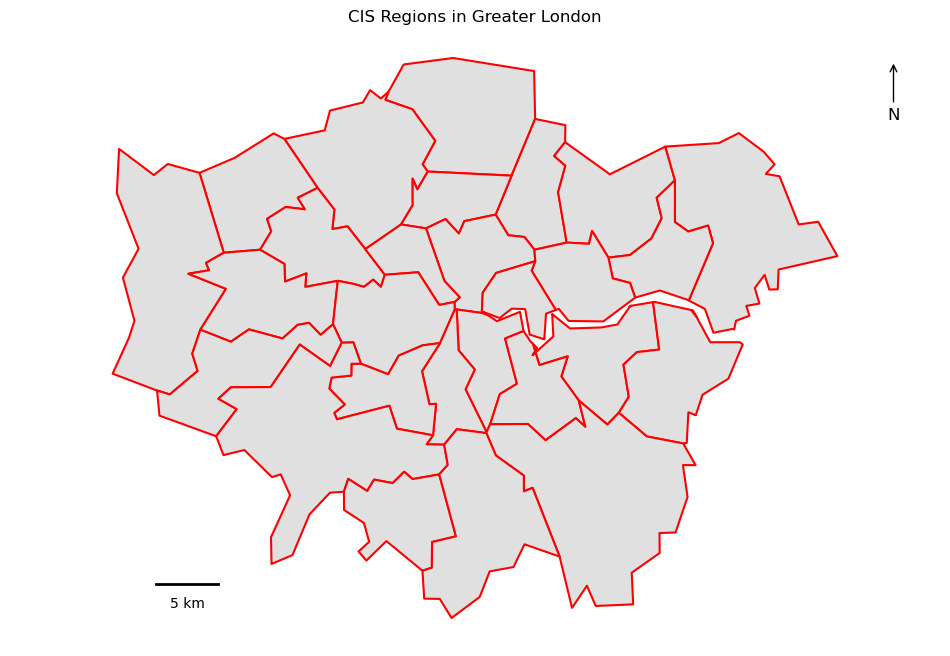


Saving London CIS codes...
Found 27 CIS regions in London
London CIS codes saved to '../data/processed/london_cis_codes.csv'


In [1]:
# 1. Set up PROJ data directory and import libraries
import os
import warnings
warnings.filterwarnings('ignore')

# Set up the PROJ data directory environment variable
try:
    import pyproj
    proj_data_dir = pyproj.datadir.get_data_dir()
    os.environ['PROJ_DATA'] = proj_data_dir
    print(f"✓ PROJ_DATA set to: {proj_data_dir}")
except Exception as e:
    print(f"Warning: Could not set PROJ_DATA: {e}")
    # Try some common paths
    possible_paths = [
        '/opt/anaconda3/share/proj',
        '/usr/share/proj', 
        '/usr/local/share/proj',
        '/opt/homebrew/share/proj'
    ]
    for path in possible_paths:
        if os.path.exists(path):
            os.environ['PROJ_DATA'] = path
            print(f"✓ Manually set PROJ_DATA to: {path}")
            break

# Import other libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from shapely.geometry import Point, Polygon
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import seaborn as sns

# 2. Read data and perform spatial analysis
# Read London LSOA boundary
print("Reading London boundary data...")
london_file = '../data/raw/Boundaries data/London_LSOA_Boundaries/LSOA_2011_London_gen_MHW.shp'

try:
    # Try with fiona engine first (more stable for CRS issues)
    london_lsoa = gpd.read_file(london_file, engine='fiona')
    print("✓ Successfully read London data with fiona")
except Exception as e:
    print(f"Fiona failed: {e}")
    try:
        # Fallback to pyogrio
        london_lsoa = gpd.read_file(london_file, engine='pyogrio')
        print("✓ Successfully read London data with pyogrio")
    except Exception as e2:
        print(f"All engines failed: {e2}")
        raise

# Merge to create Greater London boundary
london_boundary = london_lsoa.dissolve()
print("London boundary CRS:", london_boundary.crs)
print("London area (km²):", london_boundary.area.iloc[0] / 1e6)

# Read CIS boundary
print("\nReading CIS boundary data...")
cis_file = '../data/raw/Boundaries data/Covid_Infection_Survey_Dec_2020_UK_BUC_-6314666778913437735/CIS_DEC_2020_UK_BUC.shp'

try:
    # Try with fiona engine first
    cis_boundary = gpd.read_file(cis_file, engine='fiona')
    print("✓ Successfully read CIS data with fiona")
except Exception as e:
    print(f"Fiona failed for CIS: {e}")
    try:
        # Fallback to pyogrio
        cis_boundary = gpd.read_file(cis_file, engine='pyogrio')
        print("✓ Successfully read CIS data with pyogrio")
    except Exception as e2:
        print(f"All engines failed for CIS: {e2}")
        raise

print("CIS boundary CRS:", cis_boundary.crs)
print("Total CIS regions:", len(cis_boundary))

# 3. Unify coordinate system
if london_boundary.crs != cis_boundary.crs:
    print("\nReprojecting to common CRS...")
    cis_boundary = cis_boundary.to_crs(london_boundary.crs)

# 4. Spatial overlay analysis
print("\nPerforming spatial overlay analysis...")
intersections = gpd.overlay(cis_boundary, london_boundary, how='intersection')
intersections['overlap_area'] = intersections.area
original_areas = cis_boundary.area

# Calculate overlap percentages
intersection_percentages = {}
for idx, row in intersections.iterrows():
    cis_code = row['CIS20CD']
    original_area = original_areas[cis_boundary['CIS20CD'] == cis_code].iloc[0]
    overlap_percentage = (row['overlap_area'] / original_area) * 100
    intersection_percentages[cis_code] = overlap_percentage

# Use higher overlap threshold (e.g., 75%) for accuracy
OVERLAP_THRESHOLD = 75
london_cis_codes = [code for code, percentage in intersection_percentages.items() 
                   if percentage > OVERLAP_THRESHOLD]

# 5. Output results
print(f"\nCIS regions with >{OVERLAP_THRESHOLD}% overlap with London:")
for code in london_cis_codes:
    print(f"CIS region {code}: {intersection_percentages[code]:.2f}% overlap")

# 6. Plot Greater London CIS boundary map
fig, ax = plt.subplots(figsize=(12, 8))

# Plot London CIS regions
london_cis = cis_boundary[cis_boundary['CIS20CD'].isin(london_cis_codes)]
# Add grey fill
london_cis.plot(ax=ax, edgecolor='red', facecolor='#e0e0e0', linewidth=1.5)

# Add north arrow
x, y, arrow_length = 0.95, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            xycoords='axes fraction', textcoords='axes fraction',
            ha='center', va='bottom',
            arrowprops=dict(arrowstyle='->'), fontsize=12)

# Add scale bar
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
scale_bar_length = 5000  # 5 km
x_scale = xmin + (xmax-xmin)*0.1
y_scale = ymin + (ymax-ymin)*0.1
ax.plot([x_scale, x_scale + scale_bar_length], [y_scale, y_scale], 'k-', linewidth=2)
ax.text(x_scale + scale_bar_length/2, y_scale - (ymax-ymin)*0.02, 
        '5 km', ha='center', va='top')

# Remove axes and borders
ax.set_axis_off()

plt.title('CIS Regions in Greater London')
plt.axis('equal')
plt.show()

# 7. Save London CIS codes
print("\nSaving London CIS codes...")
london_cis_df = pd.DataFrame({'CIS20CD': london_cis_codes})
london_cis_df.to_csv('../data/processed/london_cis_codes.csv', index=False)
print(f"Found {len(london_cis_codes)} CIS regions in London")
print("London CIS codes saved to '../data/processed/london_cis_codes.csv'")


=== Data quality analysis ===

1. Missing value analysis:
Empty DataFrame
Columns: [Missing value count, Missing percentage(%)]
Index: []

2. Variable distribution analysis:

=== sars_cov2_gc_l_mean ===

Basic statistics:
count      2398.000000
mean      53154.850851
std       85269.975476
min          66.500000
25%        7830.208110
50%       21382.722148
75%       64784.304937
max      790518.720052
Name: sars_cov2_gc_l_mean, dtype: float64
Original data skewness: 4.186
Original data kurtosis: 25.053
Log-transformed skewness: -0.474
Log-transformed kurtosis: 0.757

=== suspended_solids_mg_l ===

Basic statistics:
count    2398.000000
mean      233.465880
std       139.558680
min        25.000000
25%       140.000000
50%       211.680900
75%       293.296143
max      1747.076013
Name: suspended_solids_mg_l, dtype: float64
Original data skewness: 2.187
Original data kurtosis: 11.364
Log-transformed skewness: -0.302
Log-transformed kurtosis: 0.023

=== ammonia_mg_l ===

Basic statisti

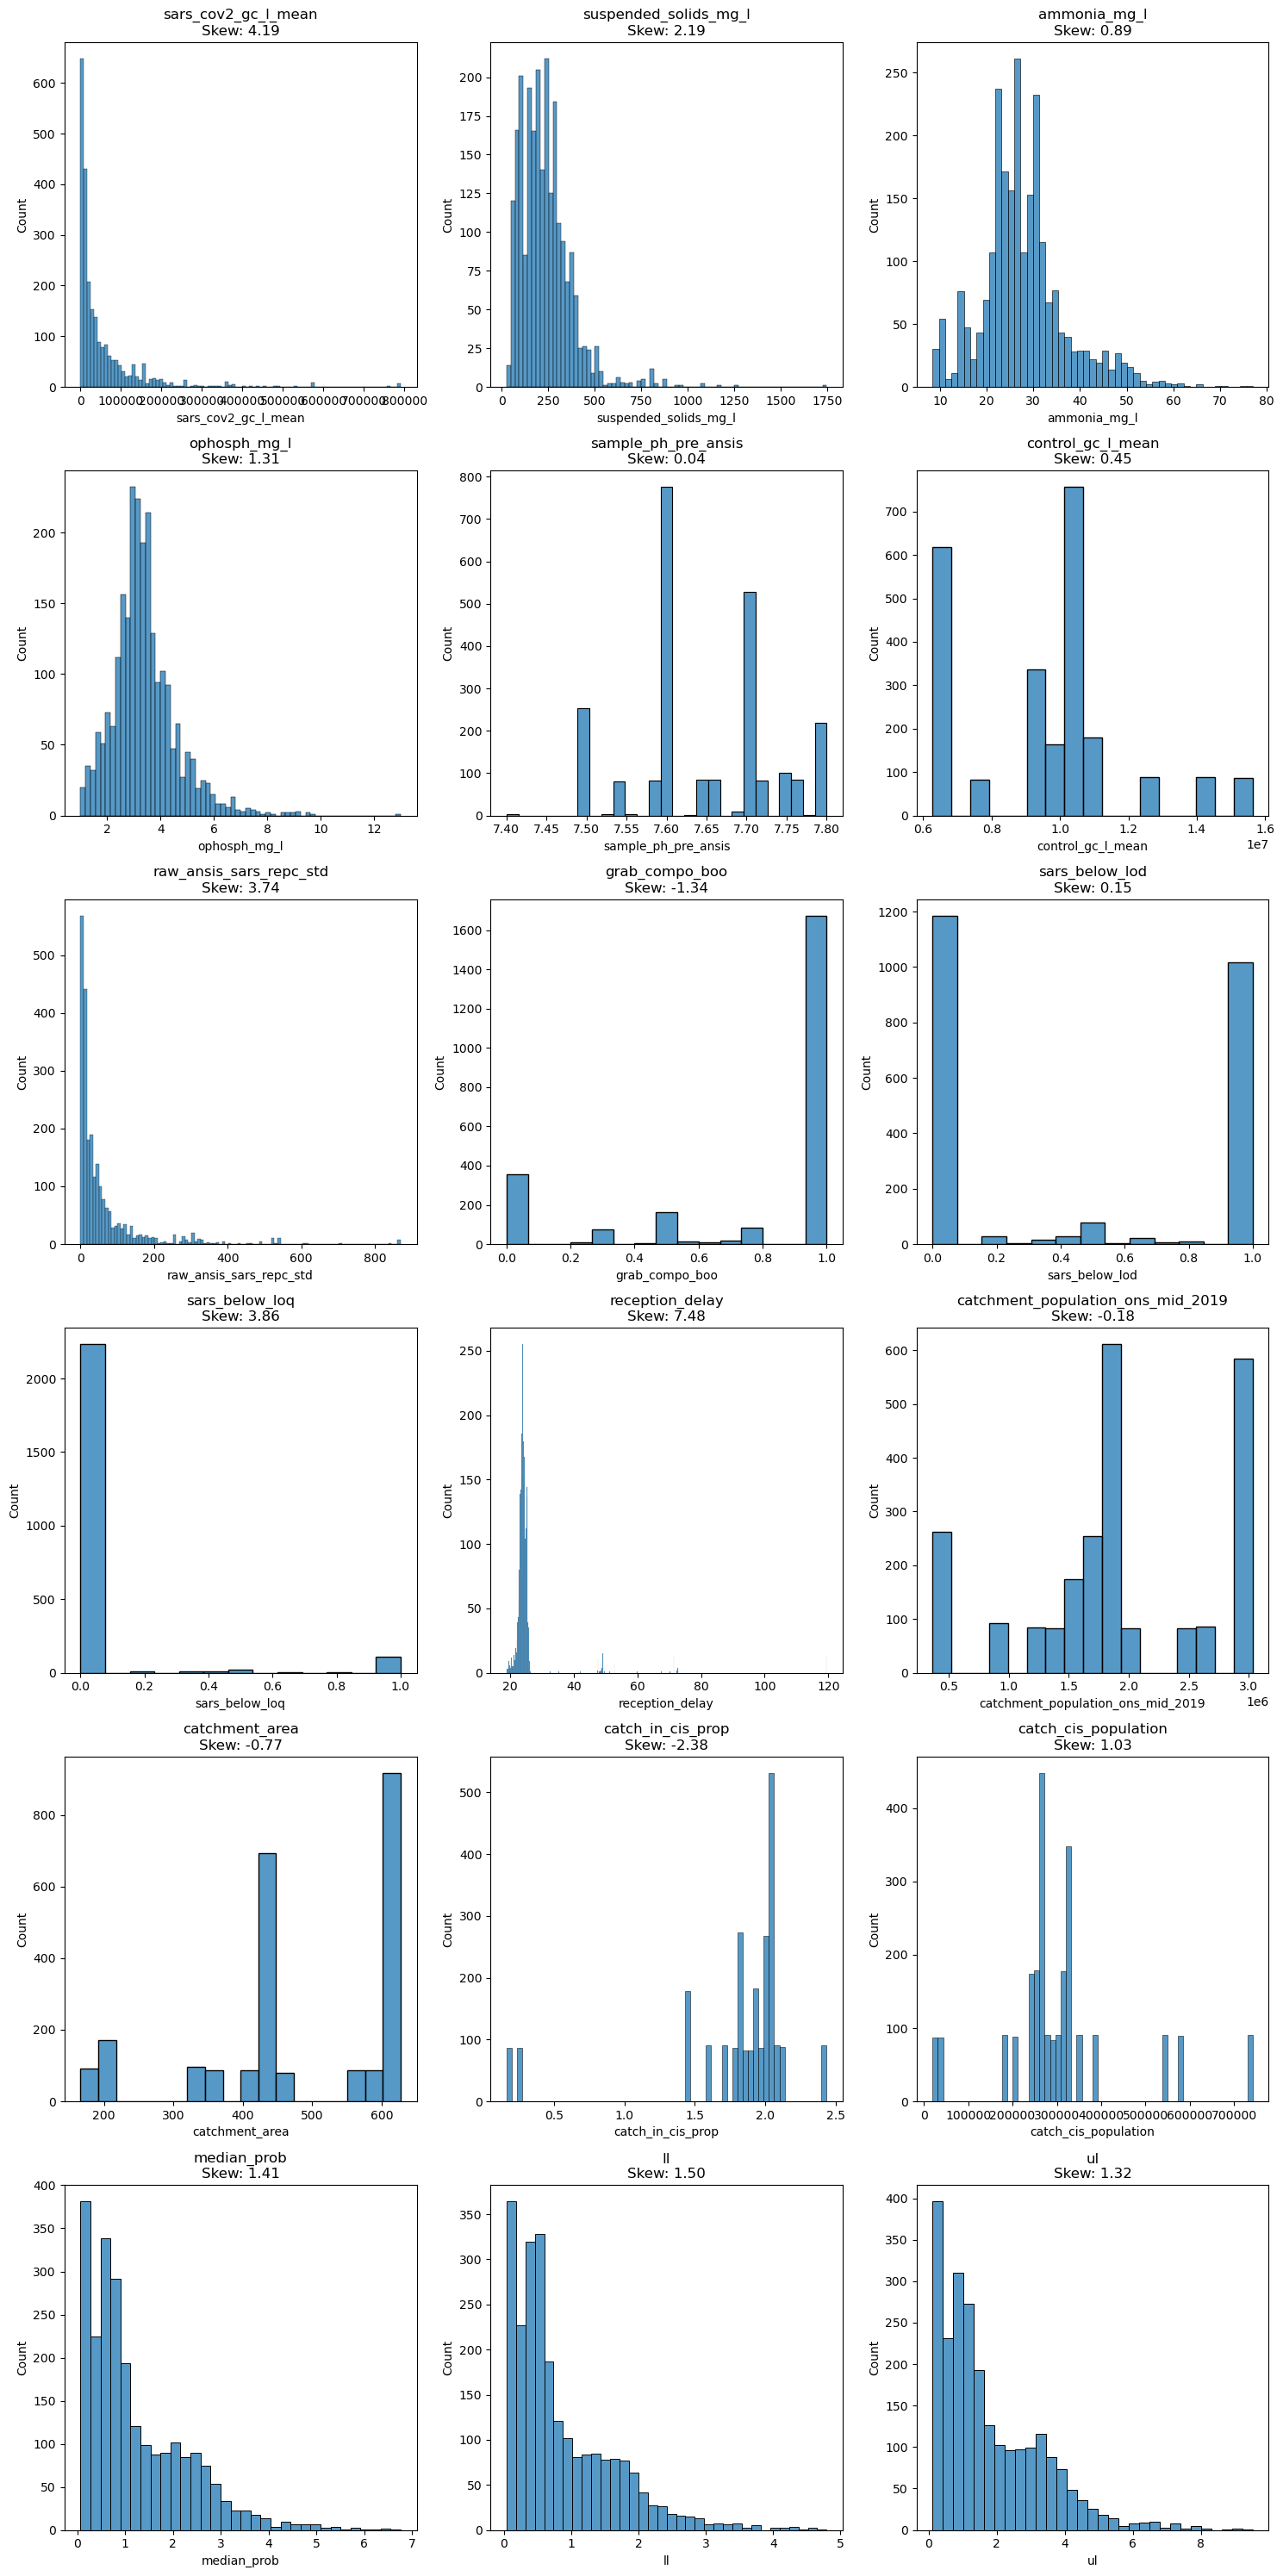


=== Data transformation summary ===
Variables that need logarithmic transformation:
- sars_cov2_gc_l_mean
  Original skewness: 4.186
  Log-transformed skewness: -0.474
- suspended_solids_mg_l
  Original skewness: 2.187
  Log-transformed skewness: -0.302
- ophosph_mg_l
  Original skewness: 1.310
  Log-transformed skewness: 0.037
- raw_ansis_sars_repc_std
  Original skewness: 3.738
  Log-transformed skewness: 0.089
- sars_below_loq
  Original skewness: 3.858
  Log-transformed skewness: 3.753
- reception_delay
  Original skewness: 7.478
  Log-transformed skewness: 5.339
- median_prob
  Original skewness: 1.407
  Log-transformed skewness: 0.505
- ll
  Original skewness: 1.503
  Log-transformed skewness: 0.689
- ul
  Original skewness: 1.319
  Log-transformed skewness: 0.327

=== Correlation analysis ===

Correlation with target variable (median_prob):
sars_cov2_gc_l_mean                  0.569219
raw_ansis_sars_repc_std              0.382465
sars_below_lod                       0.316494
s

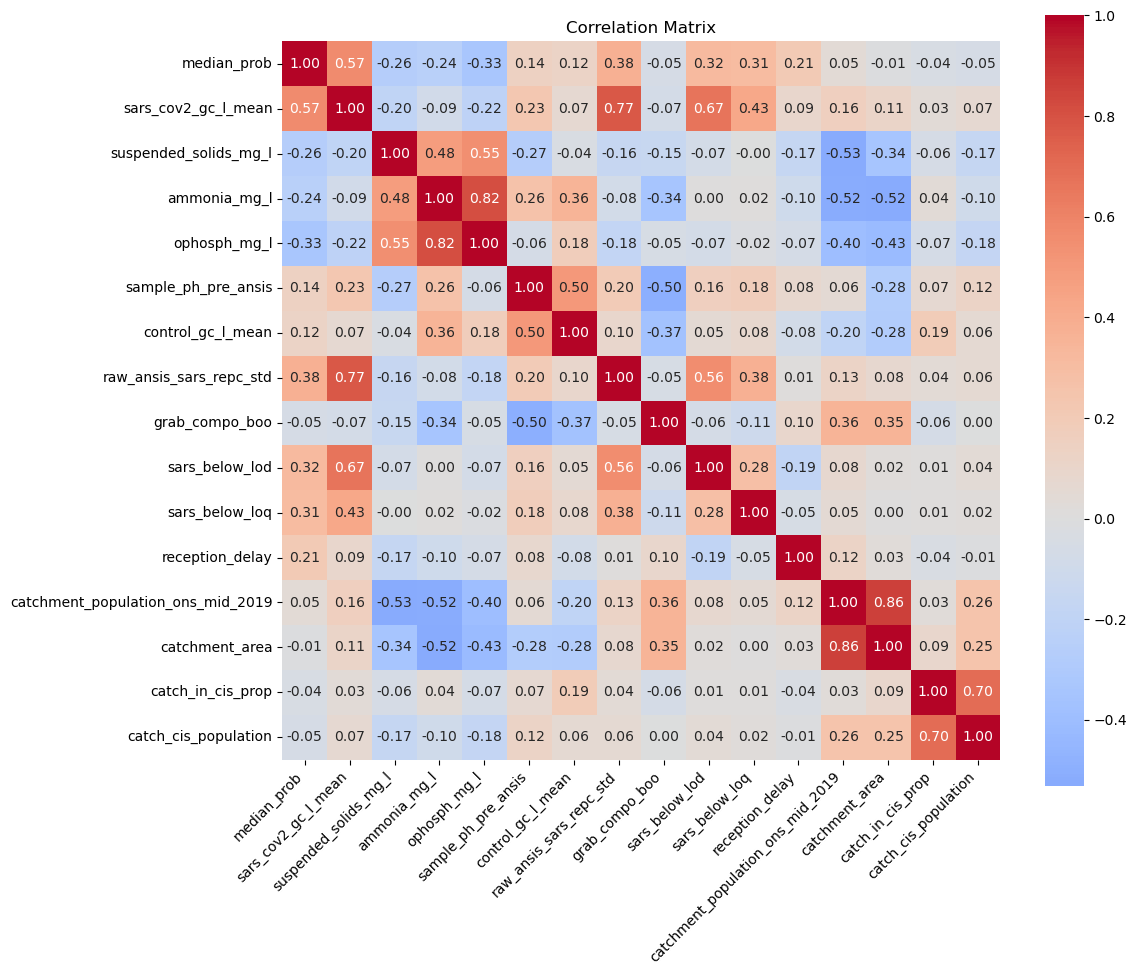


Transformed data saved to '../data/processed/london_data_transformed.csv'

=== Data processing summary ===
1. Total number of samples: 2398
2. Time range: 2020-09-04 to 2021-02-10
3. Number of CIS regions: 27
4. Number of variables that need logarithmic transformation: 9

5. Variables that need logarithmic transformation:
   - sars_cov2_gc_l_mean
   - suspended_solids_mg_l
   - ophosph_mg_l
   - raw_ansis_sars_repc_std
   - sars_below_loq
   - reception_delay
   - median_prob
   - ll
   - ul


In [2]:
# 8. Read and filter London data

df = pd.read_csv('../data/raw/agg_data_inner_11_cis_mar22.csv')
london_data = df[df['CIS20CD'].isin(london_cis_codes)]

# 9. Data cleaning and quality analysis
print("\n=== Data quality analysis ===")

# 9.1 Delete useless columns
london_data = london_data.drop(['Unnamed: 0', 'reac_vol_control'], axis=1)

# 9.2 Missing value analysis
print("\n1. Missing value analysis:")
missing_values = london_data.isnull().sum()
missing_percentages = (missing_values / len(london_data)) * 100
missing_analysis = pd.DataFrame({
    'Missing value count': missing_values,
    'Missing percentage(%)': missing_percentages
})
print(missing_analysis[missing_analysis['Missing value count'] > 0])

# 9.3 Variable distribution analysis
print("\n2. Variable distribution analysis:")
# Get all numeric variables
numeric_cols = london_data.select_dtypes(include=[np.number]).columns.tolist()

# Create a dictionary to store variables that need logarithmic transformation
transform_needed = {}

# Set subplot layout
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

# Analyze each numeric variable
for i, col in enumerate(numeric_cols):
    print(f"\n=== {col} ===")
    
    # Basic statistics
    stats = london_data[col].describe()
    print("\nBasic statistics:")
    print(stats)
    
    # Calculate skewness and kurtosis of original data
    orig_skew = london_data[col].skew()
    orig_kurt = london_data[col].kurtosis()
    print(f"Original data skewness: {orig_skew:.3f}")
    print(f"Original data kurtosis: {orig_kurt:.3f}")
    
    # Plot original data distribution
    sns.histplot(data=london_data, x=col, ax=axes[i])
    axes[i].set_title(f'{col}\nSkew: {orig_skew:.2f}')
    
    # If data is non-negative, calculate statistics after logarithmic transformation
    if london_data[col].min() >= 0:
        log_data = np.log10(london_data[col] + 1)
        log_skew = log_data.skew()
        log_kurt = log_data.kurtosis()
        print(f"Log-transformed skewness: {log_skew:.3f}")
        print(f"Log-transformed kurtosis: {log_kurt:.3f}")
        
        # Check if logarithmic transformation is needed
        if abs(orig_skew) > 1 and abs(log_skew) < abs(orig_skew):
            transform_needed[col] = {
                'orig_skew': orig_skew,
                'log_skew': log_skew
            }
    else:
        print("Data contains negative values, not recommended for logarithmic transformation")

# Delete extra subplots
for i in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# 9.4 Data transformation
print("\n=== Data transformation summary ===")
print("Variables that need logarithmic transformation:")
london_data_transformed = london_data.copy()

for col, stats in transform_needed.items():
    print(f"- {col}")
    print(f"  Original skewness: {stats['orig_skew']:.3f}")
    print(f"  Log-transformed skewness: {stats['log_skew']:.3f}")
    london_data_transformed[col] = np.log10(london_data[col] + 1)

# 9.5 Correlation analysis
print("\n=== Correlation analysis ===")

# Prepare data for correlation analysis
correlation_data = london_data_transformed.copy()
# Delete ll and ul
correlation_data = correlation_data.drop(['ll', 'ul'], axis=1)
# Only select numeric variables
numeric_cols = correlation_data.select_dtypes(include=[np.number]).columns.tolist()
# Exclude non-feature variables
exclude_cols = ['date']
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Rearrange columns, put median_prob first
cols_reordered = ['median_prob'] + [col for col in feature_cols if col != 'median_prob']
correlation_matrix = correlation_data[cols_reordered].corr()

# Print correlation with target variable
print("\nCorrelation with target variable (median_prob):")
correlations = correlation_matrix['median_prob'].sort_values(ascending=False)
# Exclude median_prob itself
print(correlations[correlations.index != 'median_prob'])

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0, 
            fmt='.2f',
            square=True)
plt.title('Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 10. Save processed data
london_data_transformed.to_csv('../data/processed/london_data_transformed.csv', index=False)
print("\nTransformed data saved to '../data/processed/london_data_transformed.csv'")

# 11. Data processing summary
print("\n=== Data processing summary ===")
print(f"1. Total number of samples: {len(london_data)}")
print(f"2. Time range: {london_data['date'].min()} to {london_data['date'].max()}")
print(f"3. Number of CIS regions: {london_data['CIS20CD'].nunique()}")
print(f"4. Number of variables that need logarithmic transformation: {len(transform_needed)}")
print("\n5. Variables that need logarithmic transformation:")
for col in transform_needed.keys():
    print(f"   - {col}")


=== London infection rate time trend analysis ===

Data time range:
Start date: 2020-09-04 00:00:00
End date: 2021-02-10 00:00:00

Infection rate statistics:
Average infection rate: 0.316%
Highest infection rate: 0.640%
Lowest infection rate: 0.042%

Trend analysis:
1. Initial phase (2020-09 to 2020-11):
   - Start infection rate: 0.042%
   - End infection rate: 0.251%
   - Characteristics: Slow upward trend, relatively stable infection rate

2. Mid-term phase (2020-11 to 2020-12):
   - Start infection rate: 0.253%
   - End infection rate: 0.452%
   - Characteristics: Infection rate increases with fluctuations, showing a slight upward trend

3. Late phase (2020-12 to 2021-02):
   - Start infection rate: 0.483%
   - End infection rate: 0.281%
   - Characteristics: Infection rate significantly increases, peaks and then starts to decrease

Overall change:
From initial value 0.042% to 0.281%
Overall change rate: 566.0%


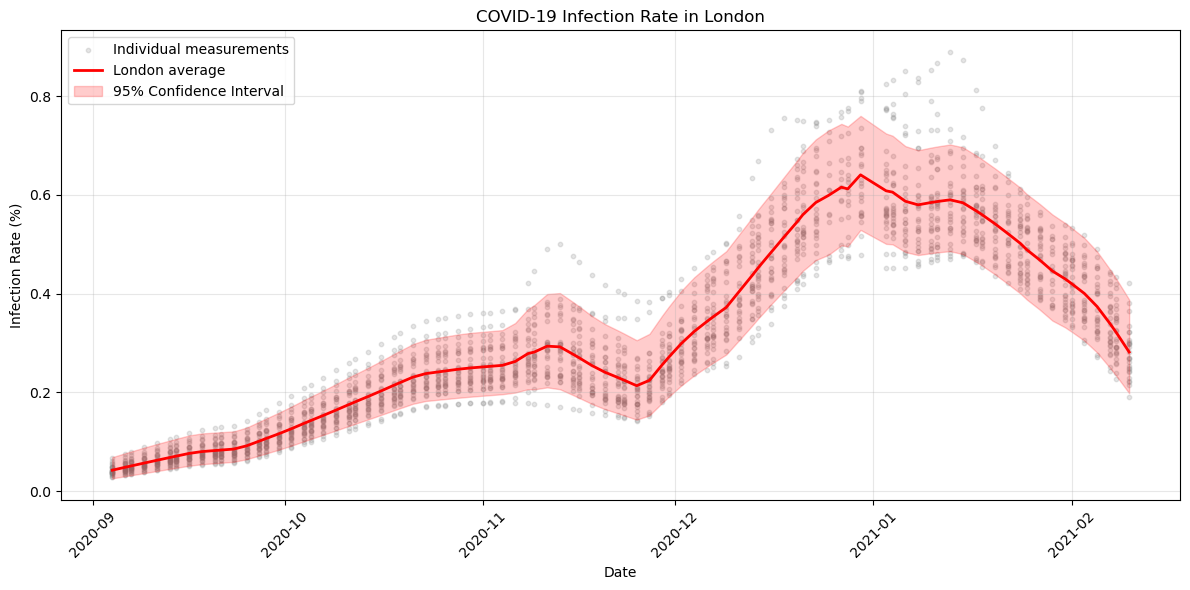

In [3]:
# Show London infection rate time trend

print("\n=== London infection rate time trend analysis ===")

# Ensure date format is correct
london_data_transformed['date'] = pd.to_datetime(london_data_transformed['date'])

# Create trend plot
plt.figure(figsize=(12, 6))

# Plot data points for each region (small dots)
for cis in london_data_transformed['CIS20CD'].unique():
    region_data = london_data_transformed[london_data_transformed['CIS20CD'] == cis]
    plt.scatter(region_data['date'], region_data['median_prob'], 
               alpha=0.2, s=10, color='gray', 
               label='Individual measurements' if cis == london_data_transformed['CIS20CD'].unique()[0] else "")

# Calculate and plot average (thick line)
daily_avg = london_data_transformed.groupby('date').agg({
    'median_prob': 'mean',
    'll': 'mean',  # Lower limit
    'ul': 'mean'   # Upper limit
}).reset_index()

# Ensure date is sorted
daily_avg = daily_avg.sort_values('date')

# Plot average line
plt.plot(daily_avg['date'], daily_avg['median_prob'], 
         color='red', linewidth=2, label='London average')

# Plot confidence interval
plt.fill_between(daily_avg['date'], 
                 daily_avg['ll'], 
                 daily_avg['ul'], 
                 alpha=0.2, color='red', 
                 label='95% Confidence Interval')

# Set month tick marks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title('COVID-19 Infection Rate in London')
plt.xlabel('Date')
plt.ylabel('Infection Rate (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# Calculate key statistical indicators and trend analysis
print("\nData time range:")
print(f"Start date: {daily_avg['date'].min()}")
print(f"End date: {daily_avg['date'].max()}")

# Calculate overall statistics
print("\nInfection rate statistics:")
print(f"Average infection rate: {daily_avg['median_prob'].mean():.3f}%")
print(f"Highest infection rate: {daily_avg['median_prob'].max():.3f}%")
print(f"Lowest infection rate: {daily_avg['median_prob'].min():.3f}%")

# Calculate trend analysis for different phases
# Divide data into three phases
phase1_end = '2020-11-01'
phase2_end = '2020-12-15'

phase1 = daily_avg[daily_avg['date'] <= phase1_end]
phase2 = daily_avg[(daily_avg['date'] > phase1_end) & (daily_avg['date'] <= phase2_end)]
phase3 = daily_avg[daily_avg['date'] > phase2_end]

print("\nTrend analysis:")
print("1. Initial phase (2020-09 to 2020-11):")
print(f"   - Start infection rate: {phase1['median_prob'].iloc[0]:.3f}%")
print(f"   - End infection rate: {phase1['median_prob'].iloc[-1]:.3f}%")
print(f"   - Characteristics: Slow upward trend, relatively stable infection rate")

print("\n2. Mid-term phase (2020-11 to 2020-12):")
print(f"   - Start infection rate: {phase2['median_prob'].iloc[0]:.3f}%")
print(f"   - End infection rate: {phase2['median_prob'].iloc[-1]:.3f}%")
print(f"   - Characteristics: Infection rate increases with fluctuations, showing a slight upward trend")

print("\n3. Late phase (2020-12 to 2021-02):")
print(f"   - Start infection rate: {phase3['median_prob'].iloc[0]:.3f}%")
print(f"   - End infection rate: {phase3['median_prob'].iloc[-1]:.3f}%")
print(f"   - Characteristics: Infection rate significantly increases, peaks and then starts to decrease")

# Calculate overall change
total_change = ((daily_avg['median_prob'].iloc[-1] - daily_avg['median_prob'].iloc[0]) / 
                daily_avg['median_prob'].iloc[0] * 100)
print(f"\nOverall change:")
print(f"From initial value {daily_avg['median_prob'].iloc[0]:.3f}% to {daily_avg['median_prob'].iloc[-1]:.3f}%")
print(f"Overall change rate: {total_change:.1f}%")

plt.show()


=== London wastewater SARS-CoV-2 RNA concentration time trend analysis ===

Concentration statistics:
Average concentration: 4.34 log10(gc/L)
Highest concentration: 5.62 log10(gc/L)
Lowest concentration: 3.27 log10(gc/L)

Trend analysis:
Start concentration: 3.44 log10(gc/L)
End concentration: 4.22 log10(gc/L)
Overall change rate: 22.7%


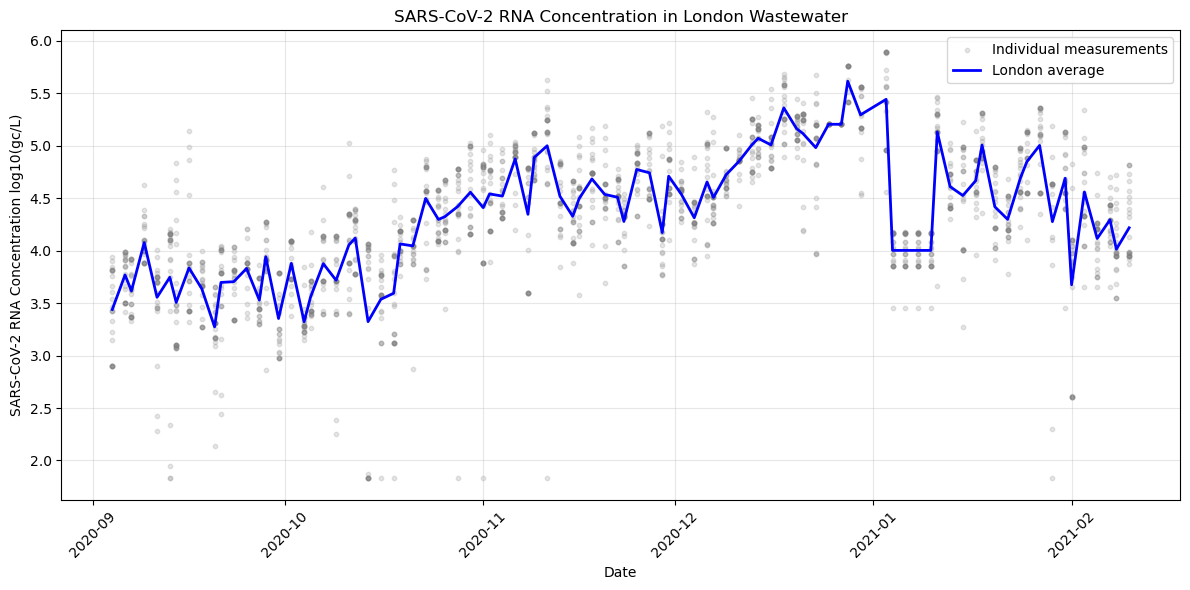

In [4]:
print("\n=== London wastewater SARS-CoV-2 RNA concentration time trend analysis ===")

# Create trend plot
plt.figure(figsize=(12, 6))

# Plot data points for each region (small dots)
for cis in london_data_transformed['CIS20CD'].unique():
    region_data = london_data_transformed[london_data_transformed['CIS20CD'] == cis]
    plt.scatter(region_data['date'], region_data['sars_cov2_gc_l_mean'], 
               alpha=0.2, s=10, color='gray', 
               label='Individual measurements' if cis == london_data_transformed['CIS20CD'].unique()[0] else "")

# Calculate and plot average (thick line)
daily_avg = london_data_transformed.groupby('date')['sars_cov2_gc_l_mean'].mean()
plt.plot(daily_avg.index, daily_avg.values, 
         color='blue', linewidth=2, label='London average')

# Set month tick marks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title('SARS-CoV-2 RNA Concentration in London Wastewater')
plt.xlabel('Date')
plt.ylabel('SARS-CoV-2 RNA Concentration log10(gc/L)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# Calculate key statistical indicators
print("\nConcentration statistics:")
print(f"Average concentration: {daily_avg.mean():.2f} log10(gc/L)")
print(f"Highest concentration: {daily_avg.max():.2f} log10(gc/L)")
print(f"Lowest concentration: {daily_avg.min():.2f} log10(gc/L)")

# Calculate change trend
start_conc = daily_avg.iloc[0]
end_conc = daily_avg.iloc[-1]
change_ratio = ((end_conc - start_conc) / start_conc) * 100

print("\nTrend analysis:")
print(f"Start concentration: {start_conc:.2f} log10(gc/L)")
print(f"End concentration: {end_conc:.2f} log10(gc/L)")
print(f"Overall change rate: {change_ratio:.1f}%")

plt.show()


=== Comparison of SARS-CoV-2 RNA concentration in London wastewater and infection rate ===

Statistical analysis:
Correlation coefficient between RNA concentration and infection rate: 0.709

RNA concentration statistics:
Average concentration: 4.34 log10(gc/L)
Highest concentration: 5.62 log10(gc/L)
Lowest concentration: 3.27 log10(gc/L)

Infection rate statistics:
Average infection rate: 0.316%
Highest infection rate: 0.640%
Lowest infection rate: 0.042%


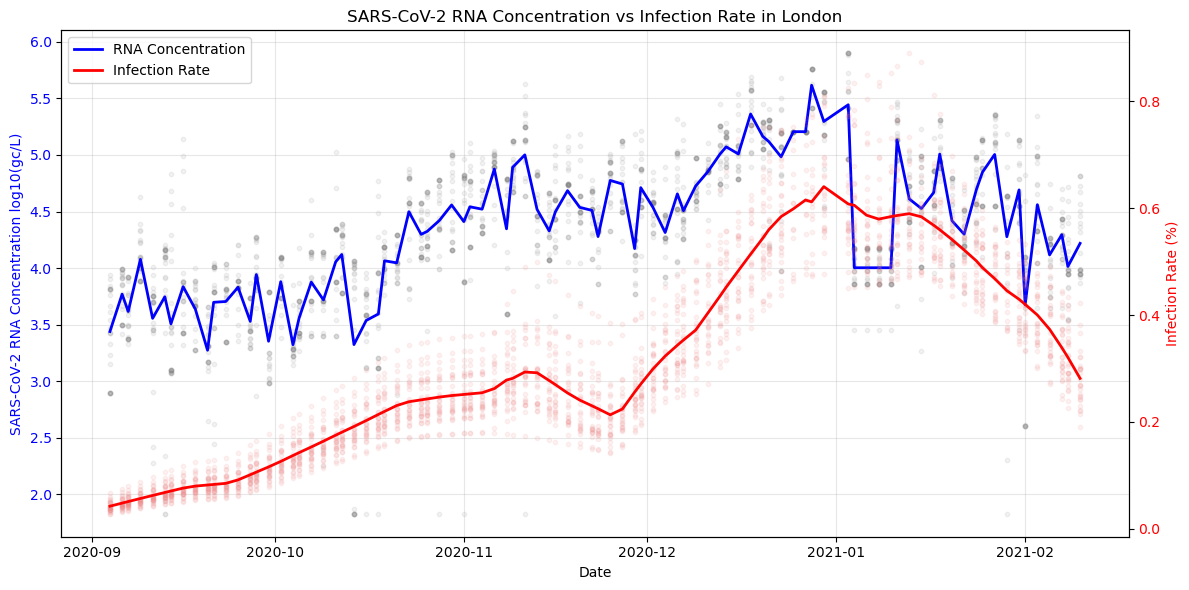

In [5]:
print("\n=== Comparison of SARS-CoV-2 RNA concentration in London wastewater and infection rate ===")

# Create double Y-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Plot RNA concentration (left Y-axis)
# Plot data points for each region
for cis in london_data_transformed['CIS20CD'].unique():
    region_data = london_data_transformed[london_data_transformed['CIS20CD'] == cis]
    ax1.scatter(region_data['date'], region_data['sars_cov2_gc_l_mean'], 
                alpha=0.1, s=10, color='gray')

# Plot average RNA concentration
daily_rna = london_data_transformed.groupby('date')['sars_cov2_gc_l_mean'].mean()
line1 = ax1.plot(daily_rna.index, daily_rna.values, 
                 color='blue', linewidth=2, label='RNA Concentration')

# Plot infection rate (right Y-axis)
# Plot data points for each region
for cis in london_data_transformed['CIS20CD'].unique():
    region_data = london_data_transformed[london_data_transformed['CIS20CD'] == cis]
    ax2.scatter(region_data['date'], region_data['median_prob'], 
                alpha=0.1, s=10, color='lightcoral')

# Plot average infection rate
daily_inf = london_data_transformed.groupby('date')['median_prob'].mean()
line2 = ax2.plot(daily_inf.index, daily_inf.values, 
                 color='red', linewidth=2, label='Infection Rate')

# Set month tick marks
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set labels and title
ax1.set_xlabel('Date')
ax1.set_ylabel('SARS-CoV-2 RNA Concentration log10(gc/L)', color='blue')
ax2.set_ylabel('Infection Rate (%)', color='red')
plt.title('SARS-CoV-2 RNA Concentration vs Infection Rate in London')

# Set axis colors
ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')

# Rotate X-axis date labels
plt.xticks(rotation=45)

# Add grid lines
ax1.grid(True, alpha=0.3)

# Merge legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.tight_layout()

# Calculate correlation coefficient
correlation = daily_rna.corr(daily_inf)

print("\nStatistical analysis:")
print(f"Correlation coefficient between RNA concentration and infection rate: {correlation:.3f}")

print("\nRNA concentration statistics:")
print(f"Average concentration: {daily_rna.mean():.2f} log10(gc/L)")
print(f"Highest concentration: {daily_rna.max():.2f} log10(gc/L)")
print(f"Lowest concentration: {daily_rna.min():.2f} log10(gc/L)")

print("\nInfection rate statistics:")
print(f"Average infection rate: {daily_inf.mean():.3f}%")
print(f"Highest infection rate: {daily_inf.max():.3f}%")
print(f"Lowest infection rate: {daily_inf.min():.3f}%")

plt.show()


=== London CIS region statistical analysis ===

CIS Region Statistics:
  CIS20CD  count  RNA_mean  RNA_std  RNA_min  RNA_max  Infection_mean  Infection_std
J06000164     86     4.449    0.633    1.829    5.686           0.350          0.204
J06000165     91     4.423    0.578    2.304    5.476           0.321          0.184
J06000166     91     4.537    0.574    3.021    5.898           0.345          0.182
J06000167     83     4.152    0.615    1.829    5.415           0.250          0.138
J06000168     91     4.491    0.596    3.031    5.881           0.399          0.228
J06000169     91     4.557    0.571    3.107    5.898           0.308          0.174
J06000170     88     3.844    0.728    1.829    5.105           0.365          0.166
J06000171     91     4.418    0.574    3.135    5.724           0.323          0.177
J06000172     91     4.341    0.541    3.127    5.761           0.375          0.217
J06000173     91     4.492    0.612    2.980    5.898           0.295         

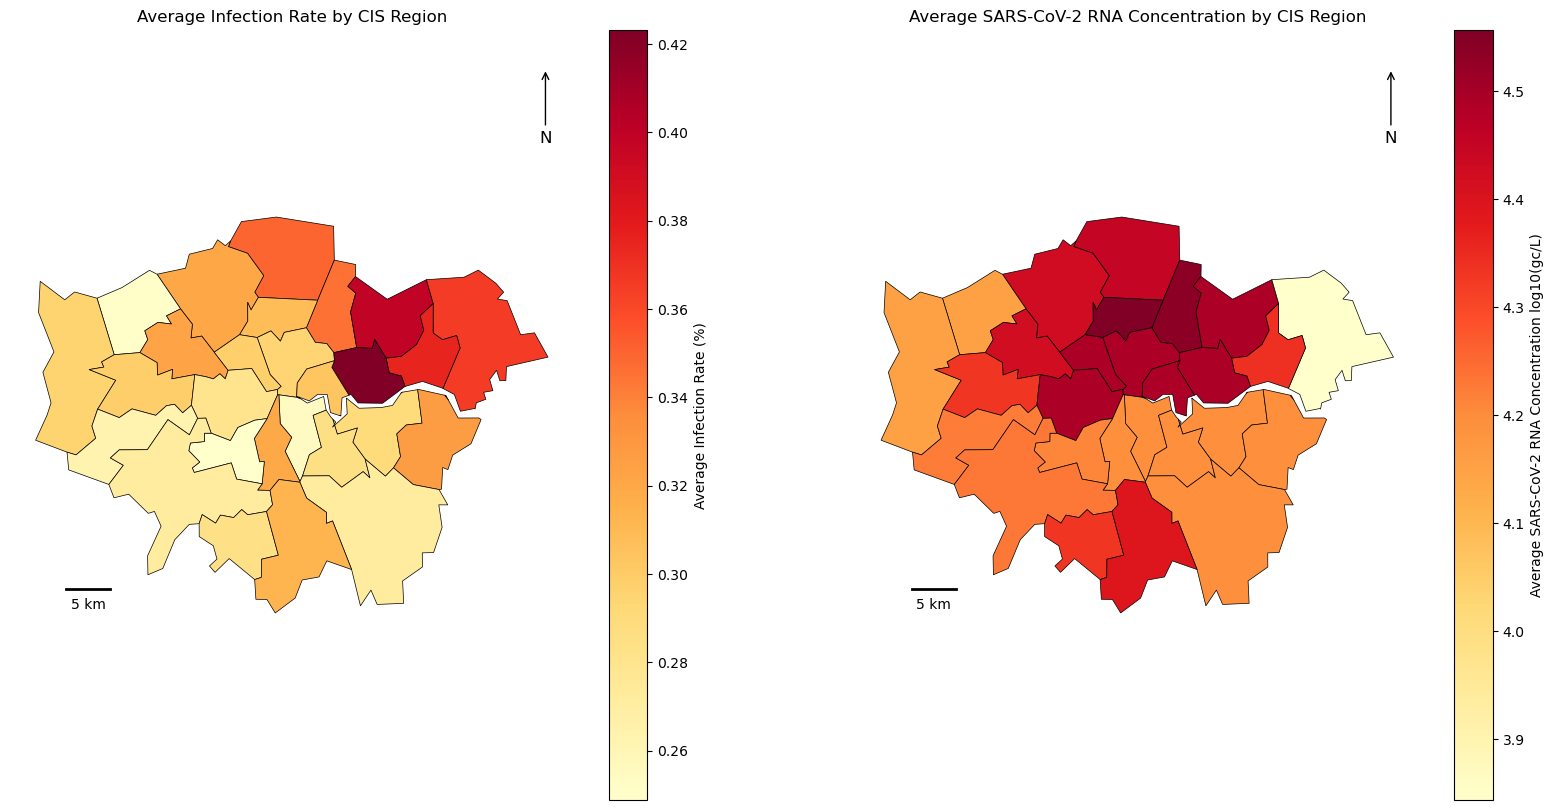

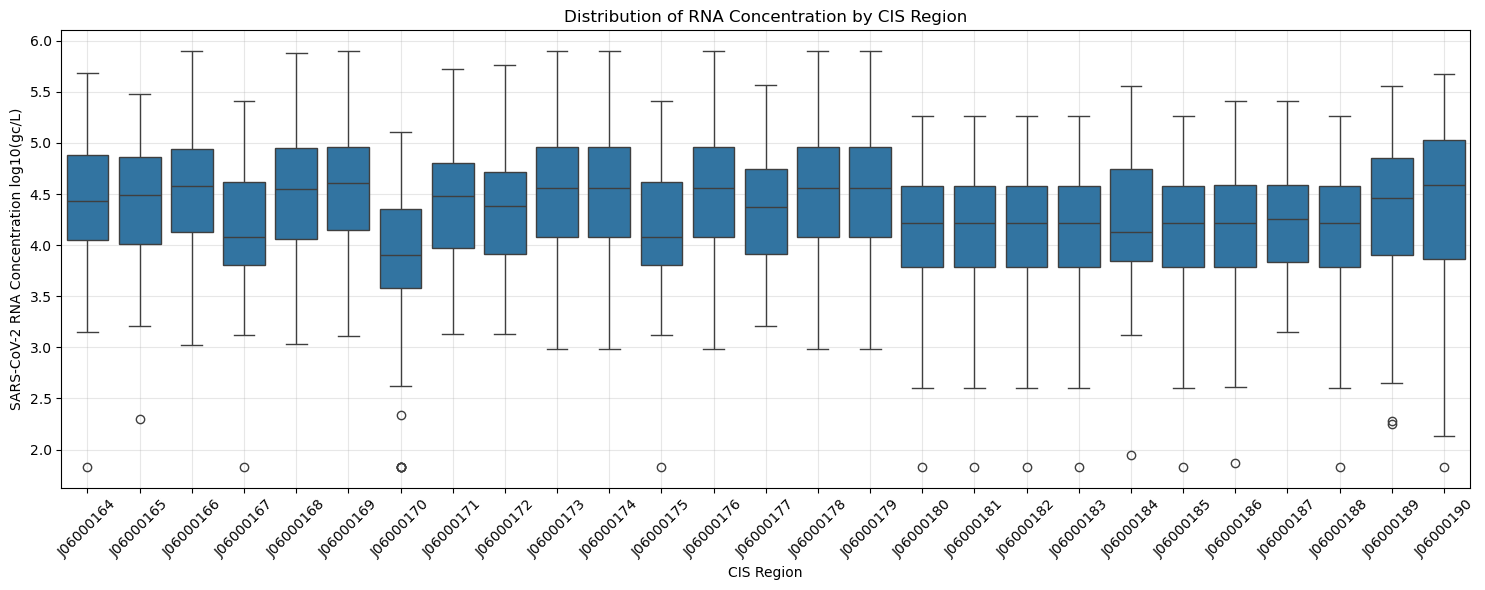


Outlier analysis:
Total number of outliers: 21

CIS regions with the most outliers:
           count  median  outliers
CIS20CD                           
J06000170     88   3.901         6
J06000189     88   4.462         2
J06000164     86   4.434         1


In [6]:
print("\n=== London CIS region statistical analysis ===")

# 1. Calculate statistics for each CIS region
spatial_stats = london_data_transformed.groupby('CIS20CD').agg({
    'median_prob': ['mean', 'std'],
    'sars_cov2_gc_l_mean': ['mean', 'std', 'min', 'max']
}).reset_index()

# Rename columns
spatial_stats.columns = ['CIS20CD', 'Infection_mean', 'Infection_std', 
                        'RNA_mean', 'RNA_std', 'RNA_min', 'RNA_max']

# Add sample count statistics
sample_counts = london_data_transformed.groupby('CIS20CD').size().reset_index(name='count')
spatial_stats = spatial_stats.merge(sample_counts, on='CIS20CD')

# Print statistics for each CIS region
print("\nCIS Region Statistics:")
print(spatial_stats[['CIS20CD', 'count', 'RNA_mean', 'RNA_std', 'RNA_min', 'RNA_max', 
                    'Infection_mean', 'Infection_std']].round(3).to_string(index=False,
                    float_format=lambda x: '{:.3f}'.format(x) if isinstance(x, float) else str(x)))

# Print key statistical findings
print("\nKey Findings:")
print(f"Number of CIS regions: {len(spatial_stats)}")

print("\nRNA Concentration Statistics:")
print(f"Minimum average: {spatial_stats['RNA_mean'].min():.3f}")
print(f"Maximum average: {spatial_stats['RNA_mean'].max():.3f}")
print(f"Range: {spatial_stats['RNA_mean'].max() - spatial_stats['RNA_mean'].min():.3f}")

print("\nInfection Rate Statistics:")
print(f"Minimum average: {spatial_stats['Infection_mean'].min():.3f}%")
print(f"Maximum average: {spatial_stats['Infection_mean'].max():.3f}%")
print(f"Range: {spatial_stats['Infection_mean'].max() - spatial_stats['Infection_mean'].min():.3f}%")

# Create spatial distribution map
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 2, wspace=0.2)

# First subplot: infection rate spatial distribution
ax1 = fig.add_subplot(gs[0, 0])
london_cis = cis_boundary[cis_boundary['CIS20CD'].isin(london_cis_codes)]
london_cis = london_cis.merge(spatial_stats, on='CIS20CD')

london_cis.plot(column='Infection_mean', 
                ax=ax1,
                legend=True,
                legend_kwds={'label': 'Average Infection Rate (%)'},
                cmap='YlOrRd',
                edgecolor='black',
                linewidth=0.5)
ax1.set_title('Average Infection Rate by CIS Region')
ax1.axis('equal')
ax1.set_axis_off()

# Add compass and scale
x, y, arrow_length = 0.95, 0.95, 0.1
ax1.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            xycoords='axes fraction', textcoords='axes fraction',
            ha='center', va='bottom',
            arrowprops=dict(arrowstyle='->'), fontsize=12)

# Scale
xmin, xmax = ax1.get_xlim()
ymin, ymax = ax1.get_ylim()
scale_bar_length = 5000  # 5 km
x_scale = xmin + (xmax-xmin)*0.1
y_scale = ymin + (ymax-ymin)*0.1
ax1.plot([x_scale, x_scale + scale_bar_length], [y_scale, y_scale], 'k-', linewidth=2)
ax1.text(x_scale + scale_bar_length/2, y_scale - (ymax-ymin)*0.02, 
         '5 km', ha='center', va='top')

# Second subplot: RNA concentration spatial distribution
ax2 = fig.add_subplot(gs[0, 1])
london_cis.plot(column='RNA_mean', 
                ax=ax2,
                legend=True,
                legend_kwds={'label': 'Average SARS-CoV-2 RNA Concentration log10(gc/L)'},
                cmap='YlOrRd',
                edgecolor='black',
                linewidth=0.5)
ax2.set_title('Average SARS-CoV-2 RNA Concentration by CIS Region')
ax2.axis('equal')
ax2.set_axis_off()

# Add compass and scale
ax2.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            xycoords='axes fraction', textcoords='axes fraction',
            ha='center', va='bottom',
            arrowprops=dict(arrowstyle='->'), fontsize=12)

x_scale = xmin + (xmax-xmin)*0.1
y_scale = ymin + (ymax-ymin)*0.1
ax2.plot([x_scale, x_scale + scale_bar_length], [y_scale, y_scale], 'k-', linewidth=2)
ax2.text(x_scale + scale_bar_length/2, y_scale - (ymax-ymin)*0.02, 
         '5 km', ha='center', va='top')

plt.show()

# Create boxplot
plt.figure(figsize=(15, 6))
sns.boxplot(x='CIS20CD', y='sars_cov2_gc_l_mean', data=london_data_transformed)
plt.title('Distribution of RNA Concentration by CIS Region')
plt.xlabel('CIS Region')
plt.ylabel('SARS-CoV-2 RNA Concentration log10(gc/L)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate boxplot statistics for each CIS region
boxplot_stats = london_data_transformed.groupby('CIS20CD')['sars_cov2_gc_l_mean'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('Q1', lambda x: x.quantile(0.25)),
    ('median', 'median'),
    ('Q3', lambda x: x.quantile(0.75)),
    ('max', 'max')
]).round(3)

# Calculate outliers
def get_outliers(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = group[(group < lower_bound) | (group > upper_bound)]
    return len(outliers)

boxplot_stats['outliers'] = london_data_transformed.groupby('CIS20CD')['sars_cov2_gc_l_mean'].apply(get_outliers)
boxplot_stats['IQR'] = boxplot_stats['Q3'] - boxplot_stats['Q1']

# Find regions with the most outliers
print("\nOutlier analysis:")
outliers_most = boxplot_stats.nlargest(3, 'outliers')
print(f"Total number of outliers: {boxplot_stats['outliers'].sum()}")
print("\nCIS regions with the most outliers:")
print(outliers_most[['count', 'median', 'outliers']].to_string())


=== London wastewater RNA concentration and infection rate moving average trend analysis ===


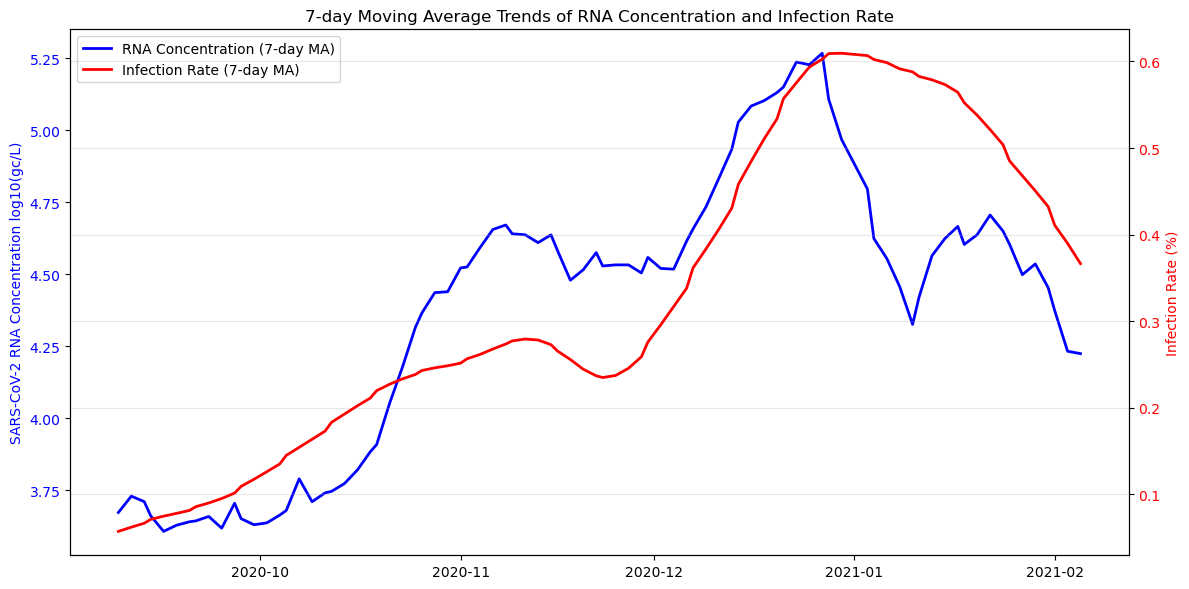


Moving average statistics analysis:

RNA concentration (7-day moving average):
count    85.000
mean      4.373
std       0.480
min       3.608
25%       3.820
50%       4.520
75%       4.637
max       5.267
Name: MA7_rna, dtype: float64

Infection rate (7-day moving average):
count    85.000
mean      0.324
std       0.176
min       0.057
25%       0.202
50%       0.273
75%       0.485
max       0.610
Name: MA7_infection, dtype: float64

Correlation coefficient between RNA concentration and infection rate (7-day moving average): 0.806


In [7]:
print("\n=== London wastewater RNA concentration and infection rate moving average trend analysis ===")

# 1. Calculate daily average
daily_avg = london_data_transformed.groupby('date').agg({
    'sars_cov2_gc_l_mean': 'mean',
    'median_prob': 'mean'
}).reset_index()

# 2. Calculate 7-day moving average
daily_avg['MA7_rna'] = daily_avg['sars_cov2_gc_l_mean'].rolling(window=7, center=True).mean()
daily_avg['MA7_infection'] = daily_avg['median_prob'].rolling(window=7, center=True).mean()

# 3. Plot double Y-axis trend chart
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# RNA concentration (left Y-axis)
line1 = ax1.plot(daily_avg['date'], daily_avg['MA7_rna'], 
                 color='blue', linewidth=2, label='RNA Concentration (7-day MA)')
ax1.set_ylabel('SARS-CoV-2 RNA Concentration log10(gc/L)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Infection rate (right Y-axis)
line2 = ax2.plot(daily_avg['date'], daily_avg['MA7_infection'], 
                 color='red', linewidth=2, label='Infection Rate (7-day MA)')
ax2.set_ylabel('Infection Rate (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set month tick marks
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set chart format
plt.title('7-day Moving Average Trends of RNA Concentration and Infection Rate')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Print statistics
print("\nMoving average statistics analysis:")
print("\nRNA concentration (7-day moving average):")
print(daily_avg['MA7_rna'].describe().round(3))

print("\nInfection rate (7-day moving average):")
print(daily_avg['MA7_infection'].describe().round(3))

# 5. Calculate correlation
correlation = daily_avg['MA7_rna'].corr(daily_avg['MA7_infection'])
print(f"\nCorrelation coefficient between RNA concentration and infection rate (7-day moving average): {correlation:.3f}")


=== Analysis of lag correlation between RNA concentration and infection rate ===


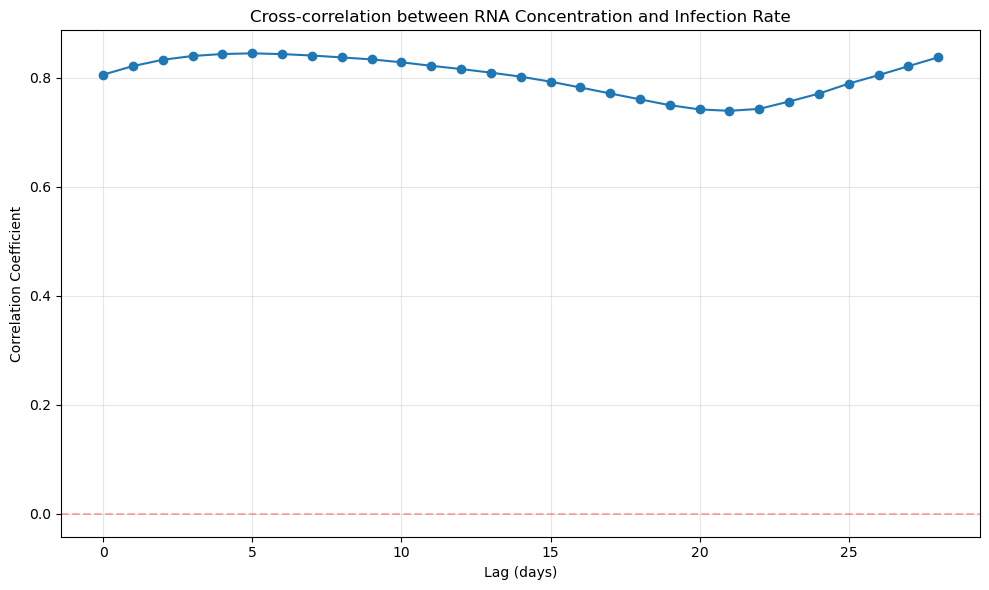


Strongest correlation occurs with a lag of 5.0 days: correlation coefficient = 0.845


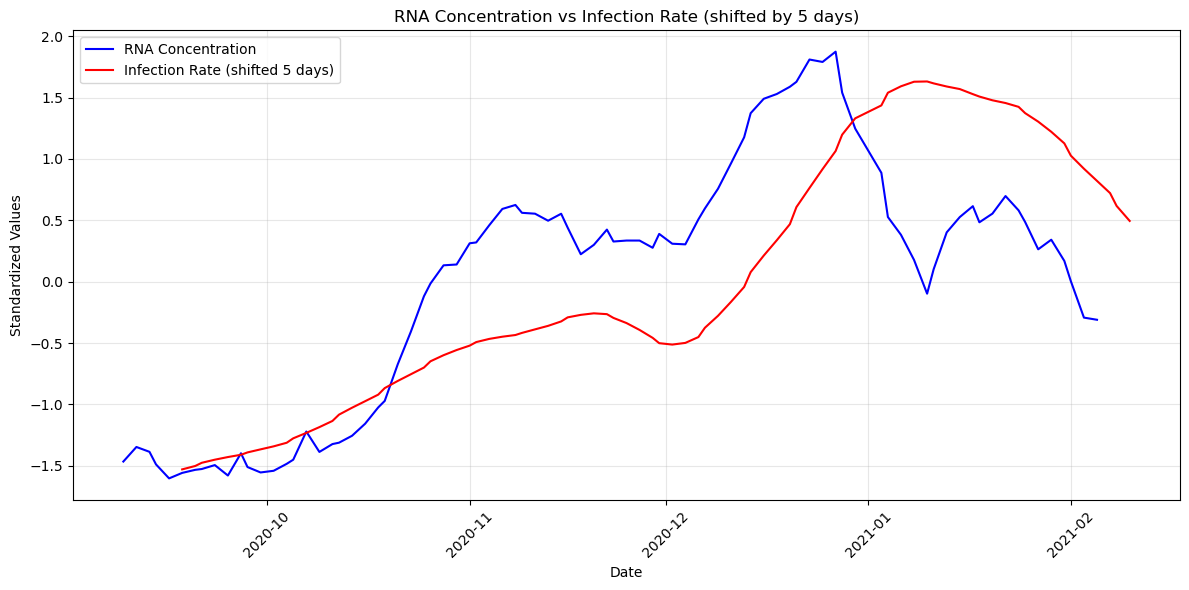


Analysis of best lag period by month:
2020-09: 11 days (r = 1.000)
2020-10: 15 days (r = 1.000)
2020-11: 16 days (r = 1.000)
2020-12: 15 days (r = -1.000)
2021-01: 15 days (r = 1.000)
2021-02: 1 days (r = 1.000)


In [8]:
print("\n=== Analysis of lag correlation between RNA concentration and infection rate ===")

# 1. Analyze lag correlation between RNA concentration and infection rate
max_lags = 28  # Analyze up to 28 days of lag
lag_correlations = []

for lag in range(max_lags + 1):
    correlation = daily_avg['MA7_rna'].corr(daily_avg['MA7_infection'].shift(-lag))
    lag_correlations.append({
        'lag': lag,
        'correlation': correlation
    })

lag_df = pd.DataFrame(lag_correlations)

# Plot lag correlation chart
plt.figure(figsize=(10, 6))
plt.plot(lag_df['lag'], lag_df['correlation'], marker='o')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.title('Cross-correlation between RNA Concentration and Infection Rate')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation Coefficient')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find the day with the strongest correlation
best_lag = lag_df.loc[lag_df['correlation'].abs().idxmax()]
print(f"\nStrongest correlation occurs with a lag of {best_lag['lag']} days: correlation coefficient = {best_lag['correlation']:.3f}")

# 2. Plot comparison chart (using the best lag time)
plt.figure(figsize=(12, 6))
best_lag_days = int(best_lag['lag'])

# Standardize data for comparison
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rna_std = scaler.fit_transform(daily_avg[['MA7_rna']])
infection_std = scaler.fit_transform(daily_avg[['MA7_infection']])

plt.plot(daily_avg['date'], rna_std, 
         label='RNA Concentration', color='blue')
plt.plot(daily_avg['date'].shift(-best_lag_days), infection_std, 
         label=f'Infection Rate (shifted {best_lag_days} days)', color='red')

plt.title(f'RNA Concentration vs Infection Rate (shifted by {best_lag_days} days)')
plt.xlabel('Date')
plt.ylabel('Standardized Values')
plt.legend()
plt.grid(True, alpha=0.3)

# Set month tick marks
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Analyze best lag period by month
monthly_lags = []
for name, group in daily_avg.groupby(daily_avg['date'].dt.strftime('%Y-%m')):
    lag_corrs = []
    for lag in range(max_lags + 1):
        corr = group['MA7_rna'].corr(group['MA7_infection'].shift(-lag))
        if not np.isnan(corr):  # Only save non-NaN correlation coefficients
            lag_corrs.append((lag, corr))
    
    if lag_corrs:  # If there are valid correlation coefficients
        best_lag = max(lag_corrs, key=lambda x: abs(x[1]))
        monthly_lags.append({
            'month': name,
            'best_lag': best_lag[0],
            'correlation': best_lag[1]
        })

print("\nAnalysis of best lag period by month:")
for month_data in monthly_lags:
    print(f"{month_data['month']}: {month_data['best_lag']} days (r = {month_data['correlation']:.3f})")

In [9]:
##### Social and economic data integration processing system (based on WBE project method)

print("=== Social and economic data integration processing system (based on WBE project method) ===")


# 1. Data loading functions
def load_all_socio_economic_data():
    """Load all socio-economic data files"""
    print("1. Load all socio-economic data files...")
    
    # Data file paths
    data_paths = {
        'imd': '../data/raw/Socio-demographic Variables data/ID 2019 for London.xlsx',
        'population_density': '../data/raw/Socio-demographic Variables data/TS006-2021-4-filtered-2025-05-27T19_38_04Z.csv',
        'age_distribution': '../data/raw/Socio-demographic Variables data/custom-filtered-2025-05-27T20_48_41Z.csv',
        'housing_occupancy': '../data/raw/Socio-demographic Variables data/TS052-2021-5-filtered-2025-05-27T20_44_13Z.csv',
        'ethnic_groups': '../data/raw/Socio-demographic Variables data/custom-filtered-2025-05-27T20_51_24Z.csv'
    }
    
    data = {}
    
    # Load IMD data
    print("  - Load IMD 2019 data...")
    data['imd'] = pd.read_excel(data_paths['imd'], sheet_name='IMD 2019')
    print(f"    IMD data shape: {data['imd'].shape}")
    
    # Load population density data
    print("  - Load population density data...")
    data['population_density'] = pd.read_csv(data_paths['population_density'])
    print(f"    Population density data shape: {data['population_density'].shape}")
    
    # Load age distribution data
    print("  - Load age distribution data...")
    data['age_distribution'] = pd.read_csv(data_paths['age_distribution'])
    print(f"    Age distribution data shape: {data['age_distribution'].shape}")
    
    # Load housing occupancy data
    print("  - Load housing occupancy data...")
    data['housing_occupancy'] = pd.read_csv(data_paths['housing_occupancy'])
    print(f"    Housing occupancy data shape: {data['housing_occupancy'].shape}")
    
    # Load ethnic distribution data
    print("  - Load ethnic distribution data...")
    data['ethnic_groups'] = pd.read_csv(data_paths['ethnic_groups'])
    print(f"    Ethnic distribution data shape: {data['ethnic_groups'].shape}")
    
    return data

def process_imd_data(imd_df):
    """Process IMD data, extract comprehensive deprivation index"""
    print("2. Process IMD data...")
    
    imd_processed = imd_df[['LSOA code (2011)', 'LSOA name (2011)', 
                           'Index of Multiple Deprivation (IMD) Score']].copy()
    imd_processed.columns = ['LSOA_Code', 'LSOA_Name', 'IMD_Score']
    
    print(f"  - Extract IMD score, data shape: {imd_processed.shape}")
    print(f"  - IMD score range: {imd_processed['IMD_Score'].min():.2f} - {imd_processed['IMD_Score'].max():.2f}")
    
    return imd_processed

def process_population_density_data(pop_df):
    """Process population density data"""
    print("3. Process population density data...")
    
    pop_processed = pop_df.copy()
    pop_processed.columns = ['LSOA_Code', 'LSOA_Name', 'Population_Density']
    
    print(f"  - Population density range: {pop_processed['Population_Density'].min():.2f} - {pop_processed['Population_Density'].max():.2f}")
    
    return pop_processed

def process_age_distribution_data(age_df):
    """Process age distribution data, calculate elderly ratio"""
    print("4. Process age distribution data...")
    
    # Pivot table: population of each age group in each LSOA
    age_pivot = age_df.pivot_table(
        index=['Lower layer Super Output Areas Code', 'Lower layer Super Output Areas'],
        columns='Age (6 categories)',
        values='Observation',
        fill_value=0
    ).reset_index()
    
    # Rename columns
    age_pivot.columns.name = None
    age_pivot.columns = ['LSOA_Code', 'LSOA_Name'] + [f'Age_{i}' for i in range(1, 7)]
    
    # Calculate total population and elderly ratio
    age_pivot['Total_Population'] = age_pivot[[f'Age_{i}' for i in range(1, 7)]].sum(axis=1)
    age_pivot['Elderly_Ratio'] = age_pivot['Age_6'] / age_pivot['Total_Population']  # Age_6 is 65 years or older
    
    # Handle zero division error
    age_pivot['Elderly_Ratio'] = age_pivot['Elderly_Ratio'].fillna(0)
    
    elderly_processed = age_pivot[['LSOA_Code', 'LSOA_Name', 'Elderly_Ratio', 'Total_Population']].copy()
    
    print(f"  - Elderly ratio range: {elderly_processed['Elderly_Ratio'].min():.3f} - {elderly_processed['Elderly_Ratio'].max():.3f}")
    print(f"  - Average elderly ratio: {elderly_processed['Elderly_Ratio'].mean():.3f}")
    
    return elderly_processed

def process_housing_occupancy_data(housing_df):
    """Process housing occupancy data, calculate crowding rate"""
    print("5. Process housing occupancy data...")
    
    # Pivot table: number of households in each occupancy rating category for each LSOA
    housing_pivot = housing_df.pivot_table(
        index=['Lower layer Super Output Areas Code', 'Lower layer Super Output Areas'],
        columns='Occupancy rating for bedrooms (6 categories)',
        values='Observation',
        fill_value=0
    ).reset_index()
    
    # Rename columns
    housing_pivot.columns.name = None
    col_names = ['LSOA_Code', 'LSOA_Name']
    for col in housing_pivot.columns[2:]:
        if 'Does not apply' in str(col):
            col_names.append('Not_Apply')
        elif '+2 or more' in str(col):
            col_names.append('Plus_2_More')
        elif '+1' in str(col):
            col_names.append('Plus_1')
        elif ': 0' in str(col):
            col_names.append('Zero')
        elif '-1' in str(col):
            col_names.append('Minus_1')
        elif '-2 or less' in str(col):
            col_names.append('Minus_2_Less')
        else:
            col_names.append('Other')
    
    housing_pivot.columns = col_names
    
    # Calculate total households and crowding rate (negative occupancy rate households)
    valid_households = housing_pivot[['Plus_2_More', 'Plus_1', 'Zero', 'Minus_1', 'Minus_2_Less']].sum(axis=1)
    overcrowded_households = housing_pivot[['Minus_1', 'Minus_2_Less']].sum(axis=1)
    
    housing_pivot['Total_Households'] = valid_households
    housing_pivot['Overcrowding_Rate'] = overcrowded_households / valid_households
    
    # Handle zero division error
    housing_pivot['Overcrowding_Rate'] = housing_pivot['Overcrowding_Rate'].fillna(0)
    
    overcrowding_processed = housing_pivot[['LSOA_Code', 'LSOA_Name', 'Overcrowding_Rate', 'Total_Households']].copy()
    
    print(f"  - Overcrowding rate range: {overcrowding_processed['Overcrowding_Rate'].min():.3f} - {overcrowding_processed['Overcrowding_Rate'].max():.3f}")
    print(f"  - Average overcrowding rate: {overcrowding_processed['Overcrowding_Rate'].mean():.3f}")
    
    return overcrowding_processed

def calculate_shannon_diversity(counts):
    """Calculate Shannon diversity index"""
    # Ensure input is numpy array
    counts = np.array(counts, dtype=float)
    
    # Remove zero and NaN values
    counts = counts[~np.isnan(counts)]
    counts = counts[counts > 0]
    
    if len(counts) <= 1:
        return 0.0
    
    # Calculate proportions
    total = np.sum(counts)
    if total == 0:
        return 0.0
        
    proportions = counts / total
    
    # Calculate Shannon diversity index
    proportions = proportions[proportions > 0]
    
    if len(proportions) == 0:
        return 0.0
    
    # Calculate Shannon diversity index
    shannon_index = -np.sum(proportions * np.log(proportions))
    
    return float(shannon_index)

def process_ethnic_distribution_data(ethnic_df):
    """Process ethnic distribution data, calculate diversity index"""
    print("6. Process ethnic distribution data...")
    
    try:
        # Pivot table: population of each ethnic group in each LSOA
        ethnic_pivot = ethnic_df.pivot_table(
            index=['Lower layer Super Output Areas Code', 'Lower layer Super Output Areas'],
            columns='Ethnic group (20 categories)',
            values='Observation',
            fill_value=0
        ).reset_index()
        
        print(f"  - Pivot table created successfully, shape: {ethnic_pivot.shape}")
        
        # Rename columns
        ethnic_pivot.columns.name = None
        ethnic_pivot.columns = ['LSOA_Code', 'LSOA_Name'] + [f'Ethnic_{i}' for i in range(len(ethnic_pivot.columns)-2)]
        
        # Calculate ethnic diversity index
        ethnic_cols = [col for col in ethnic_pivot.columns if col.startswith('Ethnic_')]
        print(f"  - Number of ethnic features: {len(ethnic_cols)}")
        
        diversity_indices = []
        total_populations = []
        
        for idx, row in ethnic_pivot.iterrows():
            ethnic_counts = row[ethnic_cols].values
            ethnic_counts = np.array(ethnic_counts, dtype=float)
            
            # Calculate diversity index
            diversity = calculate_shannon_diversity(ethnic_counts)
            diversity_indices.append(diversity)
            
            # Calculate total population
            total_pop = np.sum(ethnic_counts[~np.isnan(ethnic_counts)])
            total_populations.append(total_pop)
        
        ethnic_pivot['Ethnic_Diversity_Index'] = diversity_indices
        ethnic_pivot['Total_Population_Ethnic'] = total_populations
        
        diversity_processed = ethnic_pivot[['LSOA_Code', 'LSOA_Name', 'Ethnic_Diversity_Index', 'Total_Population_Ethnic']].copy()
        
        print(f"  - Ethnic diversity index range: {diversity_processed['Ethnic_Diversity_Index'].min():.3f} - {diversity_processed['Ethnic_Diversity_Index'].max():.3f}")
        print(f"  - Average ethnic diversity index: {diversity_processed['Ethnic_Diversity_Index'].mean():.3f}")
        
        return diversity_processed
        
    except Exception as e:
        print(f"  - Ethnic data processing failed: {e}")
        return None

def merge_all_socio_data(imd_data, pop_data, age_data, housing_data, ethnic_data):
    """Merge all socio-economic data"""
    print("7. Merge all LSOA-level socio-economic data...")
    
    # Start with IMD data
    merged_data = imd_data.copy()
    
    # Merge other data one by one
    merged_data = merged_data.merge(pop_data[['LSOA_Code', 'Population_Density']], 
                                   on='LSOA_Code', how='left')
    
    merged_data = merged_data.merge(age_data[['LSOA_Code', 'Elderly_Ratio']], 
                                   on='LSOA_Code', how='left')
    
    merged_data = merged_data.merge(housing_data[['LSOA_Code', 'Overcrowding_Rate']], 
                                   on='LSOA_Code', how='left')
    
    if ethnic_data is not None:
        merged_data = merged_data.merge(ethnic_data[['LSOA_Code', 'Ethnic_Diversity_Index']], 
                                       on='LSOA_Code', how='left')
    else:
        merged_data['Ethnic_Diversity_Index'] = 0.0
        print("  - Use default ethnic diversity index 0.0")
    
    print(f"  - Merged data shape: {merged_data.shape}")
    print(f"  - Missing value statistics:")
    for col in ['IMD_Score', 'Population_Density', 'Elderly_Ratio', 'Overcrowding_Rate', 'Ethnic_Diversity_Index']:
        missing_count = merged_data[col].isnull().sum()
        print(f"    {col}: {missing_count} ({missing_count/len(merged_data)*100:.1f}%)")
    
    return merged_data

def load_cis_lsoa_mapping():
    """Load CIS-LSOA mapping and population weights (based on WBE method)"""
    print("8. Load CIS-LSOA mapping and population weights...")
    
    # Load existing wastewater data, get CIS-LSOA mapping
    try:
        # Try to load WBE project's aggregated data as reference
        wbe_data = pd.read_csv('wbe_prevalence_england_python-main/agg_data_inner_11_cis_mar22.csv')
        print(f"  - Successfully loaded WBE aggregated data: {wbe_data.shape}")
        
        # Get CIS region list
        cis_codes = wbe_data['CIS20CD'].unique()
        print(f"  - Found {len(cis_codes)} CIS regions")
        
    except:
        print("  - WBE data not available, using existing data")
        # Use existing data
        existing_data = pd.read_csv('../data/processed/london_data_transformed.csv')
        cis_codes = existing_data['CIS20CD'].unique()
        print(f"  - Found {len(cis_codes)} CIS regions")
    
    # Load geographic boundary data for spatial mapping
    cis_boundary = gpd.read_file('../data/raw/Boundaries data/Covid_Infection_Survey_Dec_2020_UK_BUC_-6314666778913437735/CIS_DEC_2020_UK_BUC.shp')
    lsoa_boundary = gpd.read_file('../data/raw/Boundaries data/London_LSOA_Boundaries/LSOA_2011_London_gen_MHW.shp')
    
    # Unify coordinate system
    if cis_boundary.crs != lsoa_boundary.crs:
        cis_boundary = cis_boundary.to_crs(lsoa_boundary.crs)
    
    print(f"  - CIS boundary data: {len(cis_boundary)} regions")
    print(f"  - LSOA boundary data: {len(lsoa_boundary)} regions")
    
    return cis_codes, cis_boundary, lsoa_boundary

def create_cis_lsoa_population_mapping(lsoa_socio_data, cis_codes, cis_boundary, lsoa_boundary):
    """Create CIS-LSOA population weight mapping (based on WBE method)"""
    print("9. Create CIS-LSOA population weight mapping...")
    
    # Spatial join
    lsoa_with_geom = lsoa_boundary.merge(lsoa_socio_data, left_on='LSOA11CD', right_on='LSOA_Code', how='inner')
    print(f"  - LSOA geometry data matched successfully: {len(lsoa_with_geom)} regions")
    
    # Spatial overlay analysis
    print("  - Execute spatial overlay analysis...")
    spatial_join = gpd.overlay(lsoa_with_geom, cis_boundary, how='intersection')
    
    # Calculate overlap area
    spatial_join['overlap_area'] = spatial_join.geometry.area
    print(f"  - Spatial overlay completed, found {len(spatial_join)} overlapping regions")
    
    # Assign each LSOA to a CIS region and calculate population weights
    lsoa_cis_mapping = []
    
    for cis_code in cis_codes:
        if cis_code not in cis_boundary['CIS20CD'].values:
            continue
            
        # Get LSOAs overlapping with this CIS region
        overlapping_lsoas = spatial_join[spatial_join['CIS20CD'] == cis_code].copy()
        
        if len(overlapping_lsoas) == 0:
            continue
        
        # Calculate population weight for each LSOA in this CIS region
        # Use area ratio as a proxy for population distribution
        total_area = overlapping_lsoas['overlap_area'].sum()
        
        for _, lsoa_row in overlapping_lsoas.iterrows():
            # Calculate population weight for this LSOA in this CIS region
            area_weight = lsoa_row['overlap_area'] / total_area if total_area > 0 else 0
            
            # Use total population of LSOA as the base weight
            # Here we use the total population from the age distribution data
            lsoa_population = lsoa_row.get('Total_Population', 1000)  # Default 1000 if no population data
            
            # Population weight contributed by this LSOA to this CIS region
            population_weight = lsoa_population * area_weight
            
            lsoa_cis_mapping.append({
                'LSOA_Code': lsoa_row['LSOA_Code'],
                'CIS20CD': cis_code,
                'area_weight': area_weight,
                'lsoa_population': lsoa_population,
                'population_weight': population_weight
            })
    
    mapping_df = pd.DataFrame(lsoa_cis_mapping)
    print(f"  - Created {len(mapping_df)} LSOA-CIS mapping relationships")
    
    return mapping_df

def aggregate_lsoa_to_cis_wbe_style(lsoa_socio_data, mapping_df):
    """Aggregate LSOA data to CIS level using WBE-style population weighted aggregation"""
    print("10. Aggregate LSOA data to CIS level using WBE-style population weighted aggregation...")
    
    # Merge socio-economic data and mapping relationship
    data_with_mapping = mapping_df.merge(lsoa_socio_data, on='LSOA_Code', how='left')
    
    # Define socio-economic features to aggregate
    socio_features = ['IMD_Score', 'Population_Density', 'Elderly_Ratio', 'Overcrowding_Rate', 'Ethnic_Diversity_Index']
    
    # Weighted aggregation function based on WBE project
    def weighted_agg_wbe_style(variables, weight_column):
        def fn(group):
            weights = group[weight_column]
            # Filter out records with zero or NaN weights
            valid_mask = (weights > 0) & (~weights.isna())
            if valid_mask.sum() == 0:
                return pd.Series({col: np.nan for col in variables})
            
            valid_weights = weights[valid_mask]
            valid_group = group[valid_mask]
            
            result = {}
            for col in variables:
                if col in valid_group.columns:
                    valid_values = valid_group[col]
                    # Calculate weighted average only for non-NaN values
                    non_nan_mask = ~valid_values.isna()
                    if non_nan_mask.sum() > 0:
                        result[col] = np.average(
                            valid_values[non_nan_mask], 
                            weights=valid_weights[non_nan_mask]
                        )
                    else:
                        result[col] = np.nan
                else:
                    result[col] = np.nan
            return pd.Series(result)
        return fn
    
    # Apply weighted aggregation
    weighted_avg_fn = weighted_agg_wbe_style(socio_features, 'population_weight')
    cis_socio_data = data_with_mapping.groupby('CIS20CD').apply(weighted_avg_fn).reset_index()
    
    # Add additional statistics
    mapping_stats = mapping_df.groupby('CIS20CD').agg({
        'LSOA_Code': 'count',
        'population_weight': 'sum'
    }).reset_index()
    mapping_stats.columns = ['CIS20CD', 'num_lsoas', 'total_population_weight']
    
    # Merge statistics
    cis_socio_data = cis_socio_data.merge(mapping_stats, on='CIS20CD', how='left')
    
    print(f"  - Successfully aggregated {len(cis_socio_data)} CIS regions' socio-economic data")
    print(f"  - Average {mapping_stats['num_lsoas'].mean():.1f} LSOAs per CIS region")
    
    return cis_socio_data

def analyze_socio_economic_data(cis_socio_df):
    """Analyze distribution characteristics of socio-economic data"""
    print("11. Analyze CIS-level socio-economic data distribution...")
    
    feature_cols = ['IMD_Score', 'Population_Density', 'Elderly_Ratio', 'Overcrowding_Rate', 'Ethnic_Diversity_Index']
    
    print("\nSocio-economic feature statistics summary:")
    print("=" * 80)
    
    for col in feature_cols:
        if col in cis_socio_df.columns:
            stats = cis_socio_df[col].describe()
            print(f"\n{col}:")
            print(f"  - Mean: {stats['mean']:.4f}")
            print(f"  - Standard deviation: {stats['std']:.4f}")
            print(f"  - Range: {stats['min']:.4f} - {stats['max']:.4f}")
            print(f"  - Median: {stats['50%']:.4f}")
    
    # Check data quality
    print(f"\nData quality check:")
    print("=" * 80)
    for col in feature_cols:
        if col in cis_socio_df.columns:
            missing = cis_socio_df[col].isnull().sum()
            zeros = (cis_socio_df[col] == 0).sum()
            print(f"{col}: {missing} missing values, {zeros} zero values")
    
    return cis_socio_df

def save_processed_data(cis_socio_df, mapping_df):
    """Save processed data"""
    print("12. Save processed data...")
    
    # Save CIS-level socio-economic data
    cis_output_path = '../data/processed/cis_socio_economic_data.csv'
    cis_socio_df.to_csv(cis_output_path, index=False)
    print(f"  - CIS socio-economic data saved to: {cis_output_path}")
    print(f"  - Data shape: {cis_socio_df.shape}")
    
    # Save LSOA-CIS mapping relationship
    mapping_output_path = '../data/processed/lsoa_cis_mapping.csv'
    mapping_df.to_csv(mapping_output_path, index=False)
    print(f"  - LSOA-CIS mapping relationship saved to: {mapping_output_path}")
    print(f"  - Number of mapping relationships: {len(mapping_df)}")
    
    return cis_output_path, mapping_output_path

# Main execution
print("\n" + "="*80)
print("Socio-economic data integration processing system (based on WBE project method)")
print("="*80)

try:
    # Load all raw data
    raw_data = load_all_socio_economic_data()
    
    # Process various data
    imd_processed = process_imd_data(raw_data['imd'])
    pop_processed = process_population_density_data(raw_data['population_density'])
    age_processed = process_age_distribution_data(raw_data['age_distribution'])
    housing_processed = process_housing_occupancy_data(raw_data['housing_occupancy'])
    ethnic_processed = process_ethnic_distribution_data(raw_data['ethnic_groups'])
    
    # Merge all LSOA-level data
    lsoa_socio_data = merge_all_socio_data(imd_processed, pop_processed, age_processed, 
                                          housing_processed, ethnic_processed)
    
    # Load CIS-LSOA mapping
    cis_codes, cis_boundary, lsoa_boundary = load_cis_lsoa_mapping()
    
    # Create population weight mapping
    mapping_df = create_cis_lsoa_population_mapping(lsoa_socio_data, cis_codes, cis_boundary, lsoa_boundary)
    
    # Aggregate to CIS level using WBE-style population weighted aggregation
    cis_socio_data = aggregate_lsoa_to_cis_wbe_style(lsoa_socio_data, mapping_df)
    
    # Analyze data
    cis_socio_final = analyze_socio_economic_data(cis_socio_data)
    
    # Save data
    cis_output_file, mapping_output_file = save_processed_data(cis_socio_final, mapping_df)
    
    print(f"\nSocio-economic data processing completed!")
    print(f" Final features: IMD_Score, Population_Density, Elderly_Ratio, Overcrowding_Rate, Ethnic_Diversity_Index")
    print(f" CIS data output: {cis_output_file}")
    print(f" Mapping relationship output: {mapping_output_file}")
    print(f" Aggregation method: WBE project-style population weighted average")
    
except Exception as e:
    print(f" Error occurred during processing: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "="*80)
print("Socio-economic data integration processing completed!")
print("="*80)

=== Social and economic data integration processing system (based on WBE project method) ===

Socio-economic data integration processing system (based on WBE project method)
1. Load all socio-economic data files...
  - Load IMD 2019 data...
    IMD data shape: (4835, 28)
  - Load population density data...
    Population density data shape: (4994, 3)
  - Load age distribution data...
    Age distribution data shape: (29964, 5)
  - Load housing occupancy data...
    Housing occupancy data shape: (29964, 5)
  - Load ethnic distribution data...
    Ethnic distribution data shape: (99880, 5)
2. Process IMD data...
  - Extract IMD score, data shape: (4835, 3)
  - IMD score range: 2.33 - 64.68
3. Process population density data...
  - Population density range: 119.90 - 115567.00
4. Process age distribution data...
  - Elderly ratio range: 0.003 - 0.449
  - Average elderly ratio: 0.121
5. Process housing occupancy data...
  - Overcrowding rate range: 0.000 - 0.392
  - Average overcrowding rat

=== Socio-Economic Data Spatial Distribution Analysis ===
1. Loading socio-economic data...
  - CIS socio-economic data: (27, 8)
2. Loading CIS boundary data...
  - Found 27 London CIS regions
  - London CIS boundary data: 27 regions
3. Merging socio-economic data with spatial boundaries...
  - Merged data shape: (27, 10)
4. Creating spatial distribution maps...


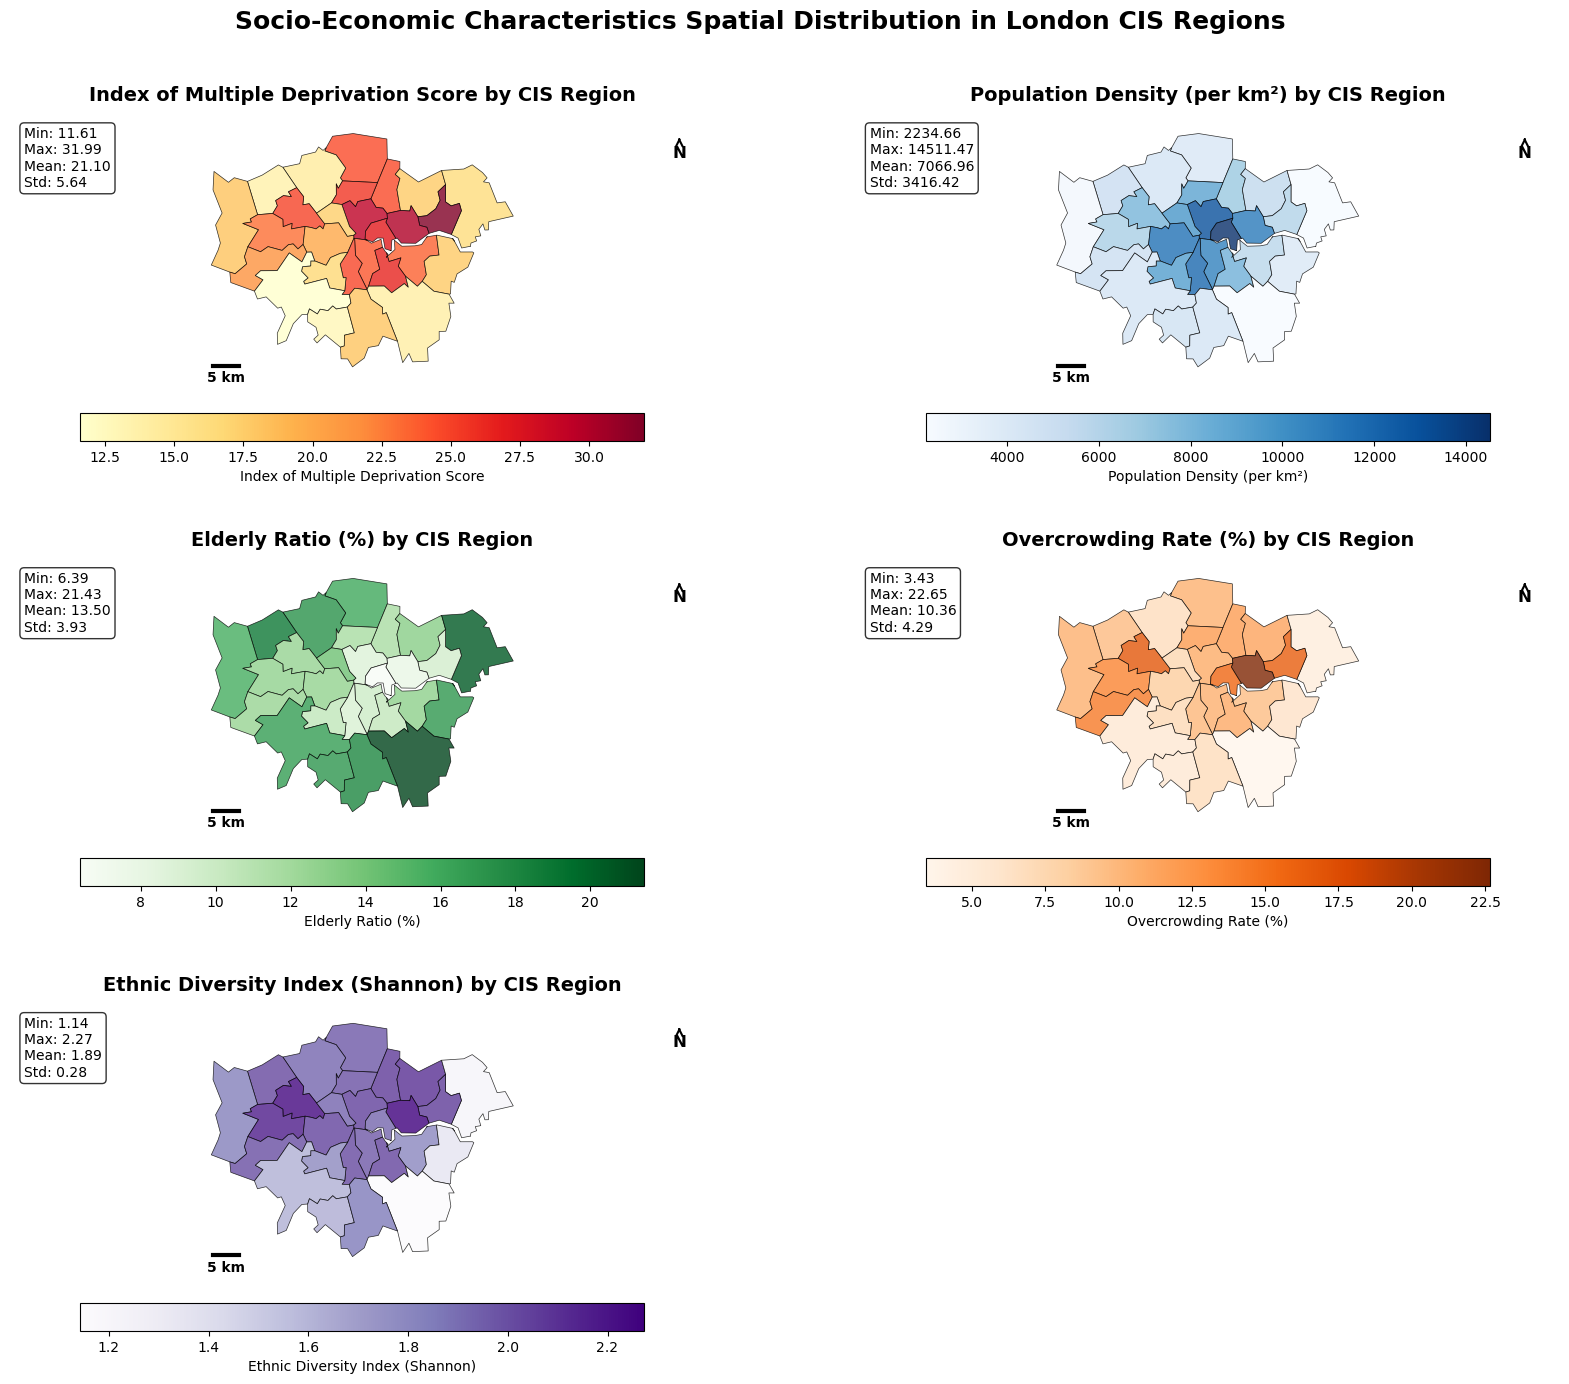

5. Creating comprehensive overview map...


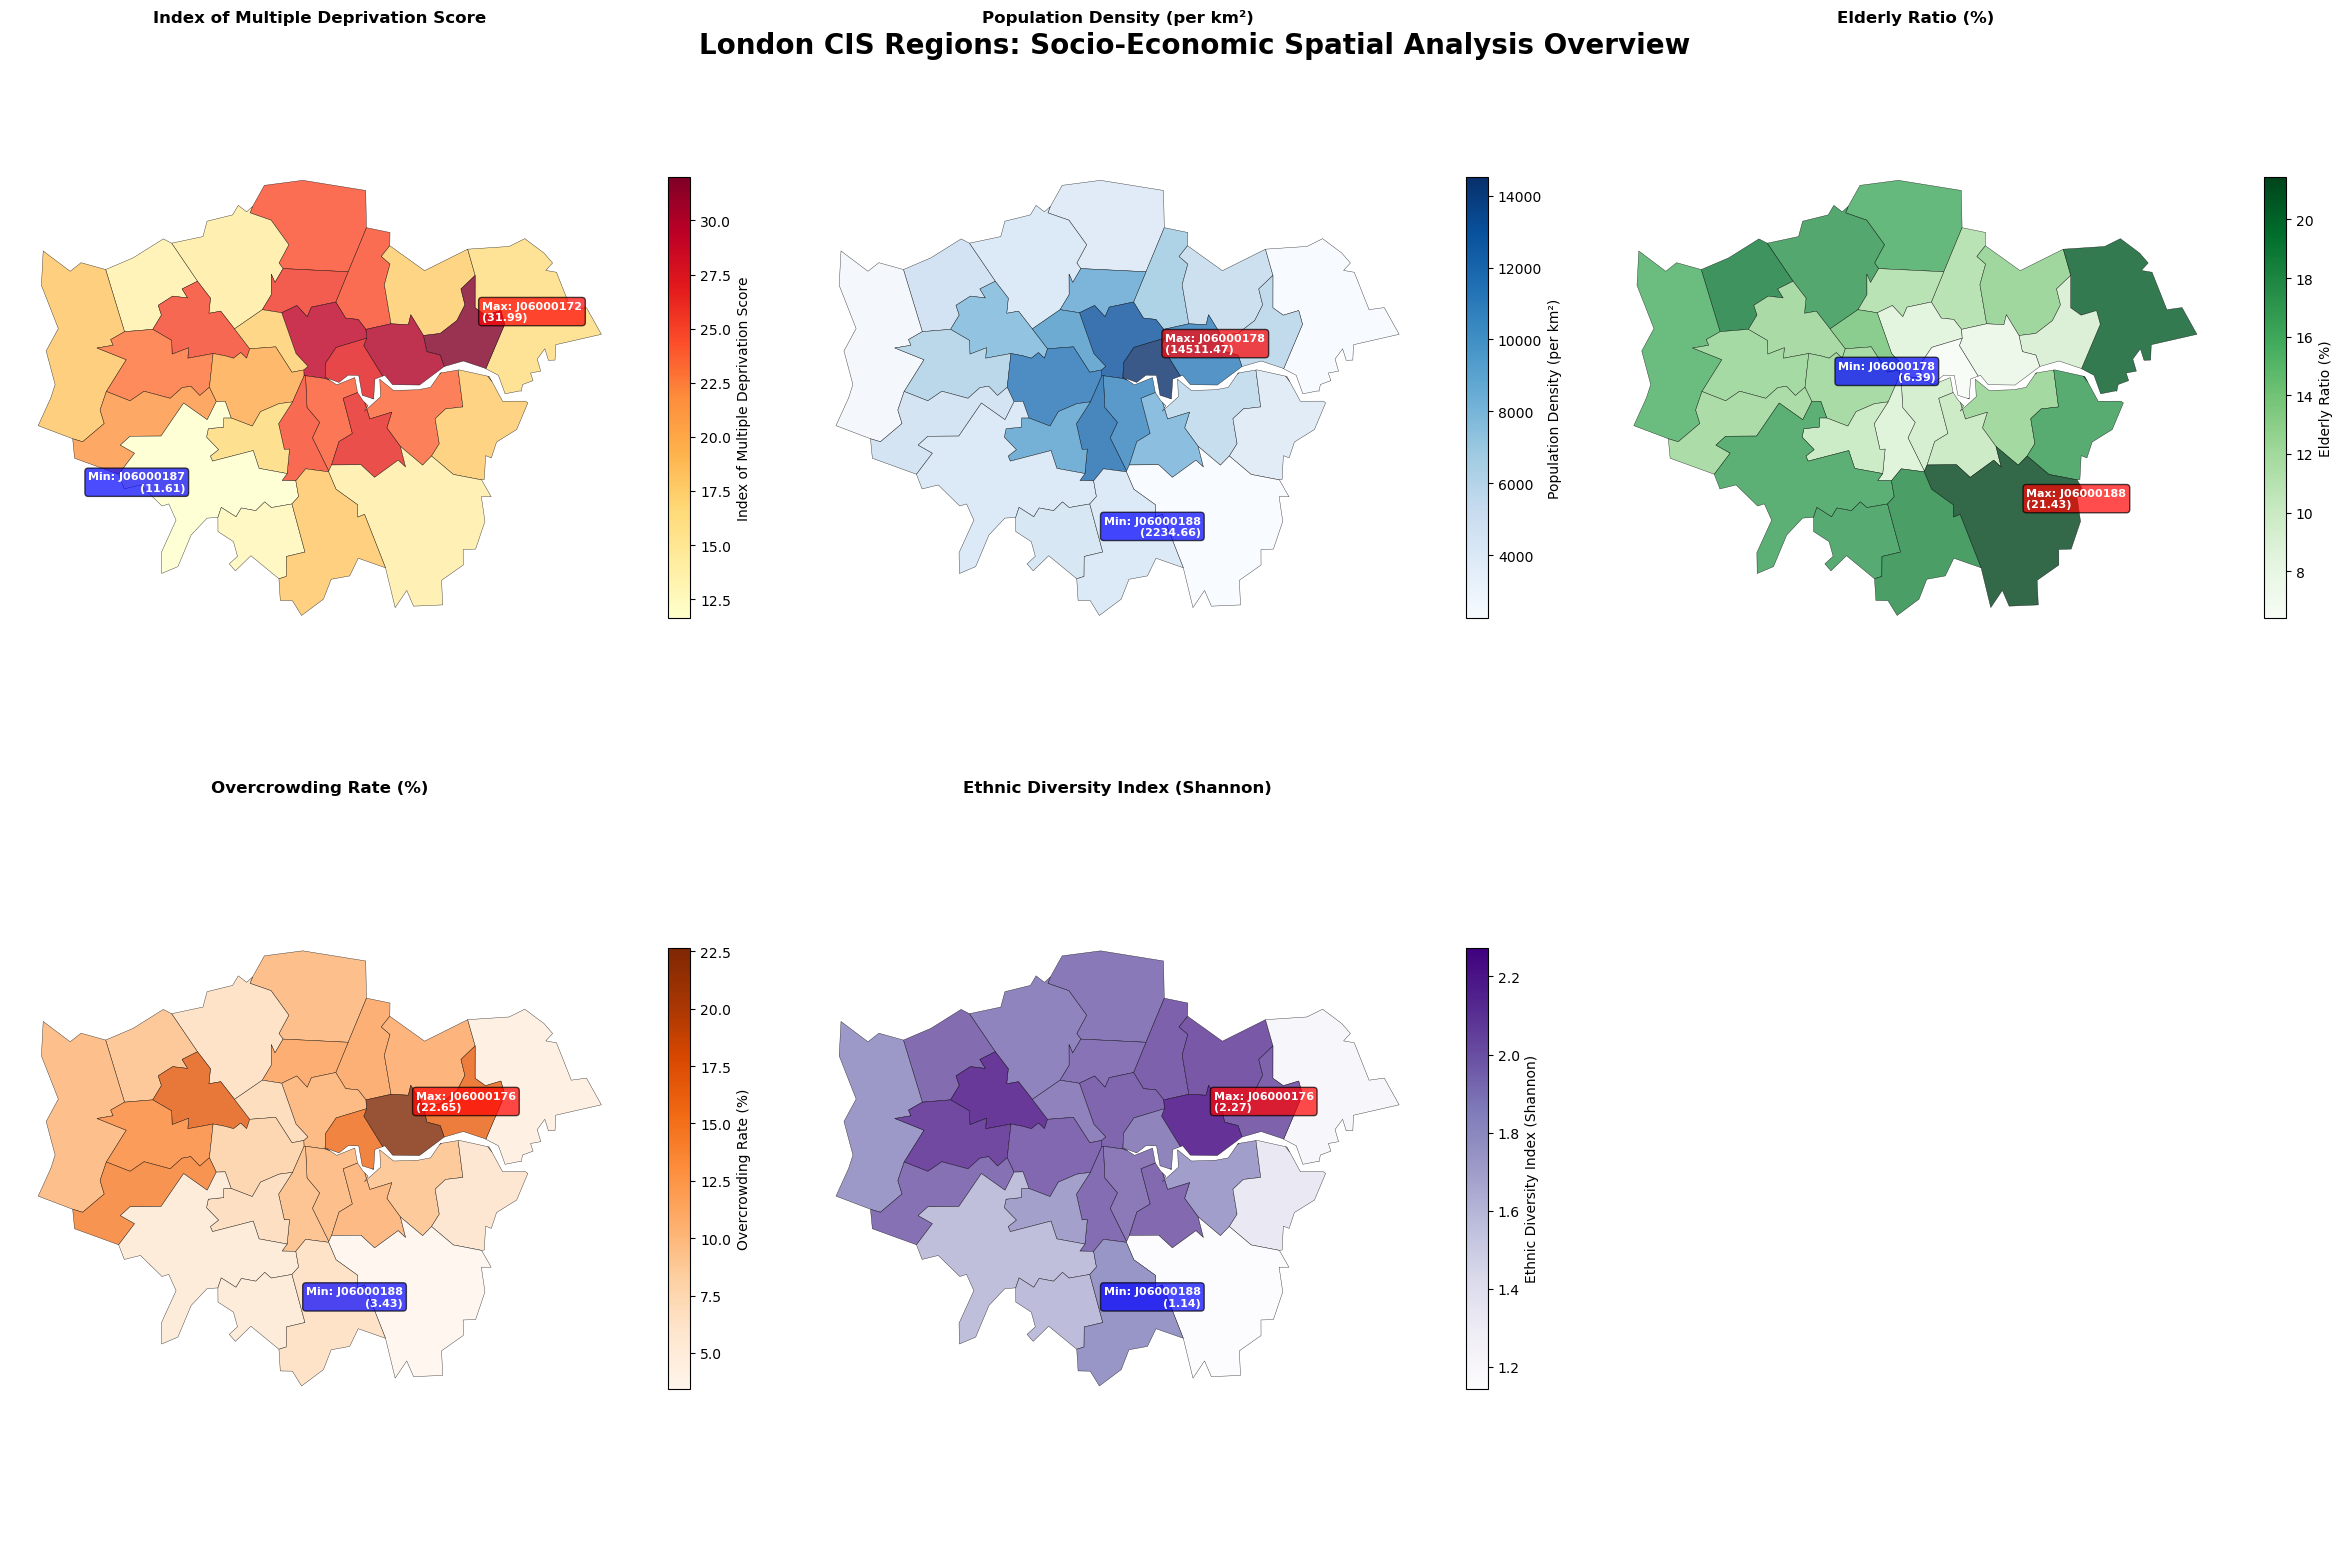

6. Creating detailed region analysis map...


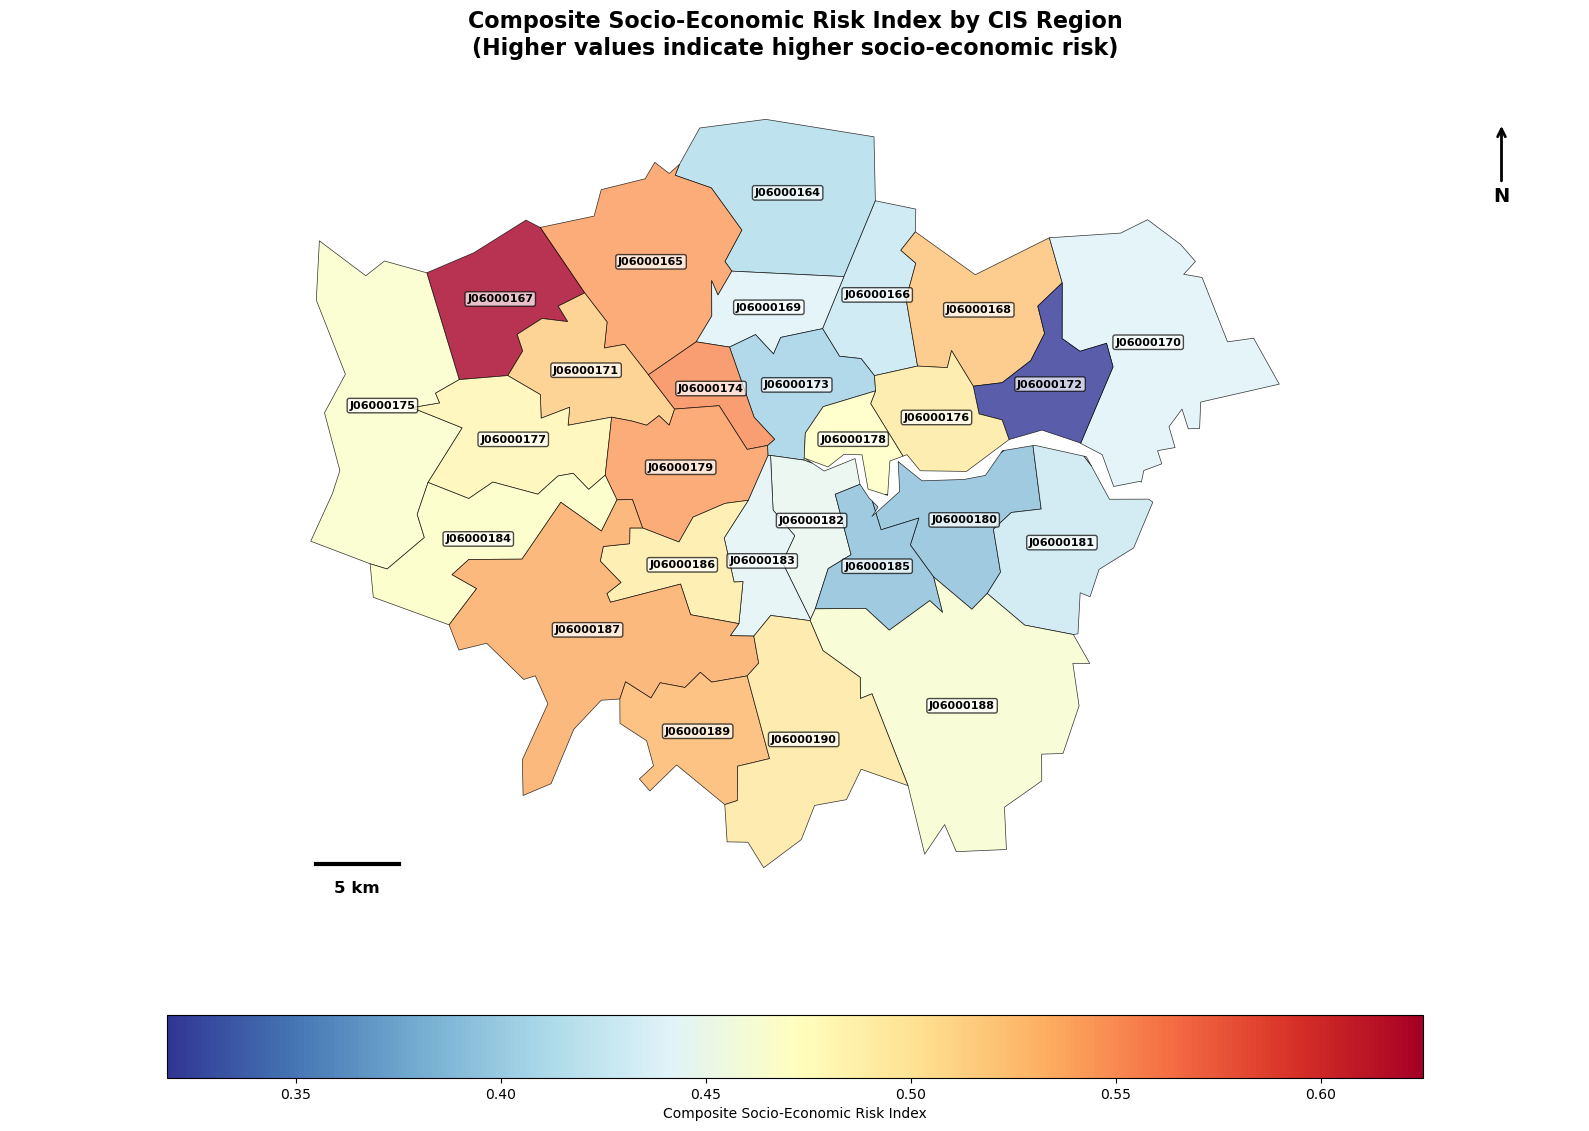


7. Regional Analysis Summary:

Index of Multiple Deprivation Score:
  Highest: J06000172 (31.992)
  Lowest:  J06000187 (11.605)
  Range:   20.386

Population Density (per km²):
  Highest: J06000178 (14511.473)
  Lowest:  J06000188 (2234.663)
  Range:   12276.809

Elderly Ratio (%):
  Highest: J06000188 (0.214)
  Lowest:  J06000178 (0.064)
  Range:   0.150

Overcrowding Rate (%):
  Highest: J06000176 (0.227)
  Lowest:  J06000188 (0.034)
  Range:   0.192

Ethnic Diversity Index (Shannon):
  Highest: J06000176 (2.273)
  Lowest:  J06000188 (1.143)
  Range:   1.130

Composite Socio-Economic Risk Index:
  Highest Risk: J06000167 (0.625)
  Lowest Risk:  J06000172 (0.319)

 Socio-economic spatial analysis completed!
 Generated 3 main spatial visualization maps:
  1. Individual feature distribution maps (5 features)
  2. Comprehensive overview with extreme value annotations
  3. Composite socio-economic risk index with region labels
 All maps include compass, scale bar, and statistical summari

In [10]:
##### Socio-Economic Data Spatial Distribution Maps

print("=== Socio-Economic Data Spatial Distribution Analysis ===")

# 1. Load data
print("1. Loading socio-economic data...")
cis_socio = pd.read_csv('../data/processed/cis_socio_economic_data.csv')
print(f"  - CIS socio-economic data: {cis_socio.shape}")

# 2. Load CIS boundary data
print("2. Loading CIS boundary data...")
cis_boundary = gpd.read_file('../data/raw/Boundaries data/Covid_Infection_Survey_Dec_2020_UK_BUC_-6314666778913437735/CIS_DEC_2020_UK_BUC.shp')

# Get London CIS codes from existing data
london_data = pd.read_csv('../data/processed/london_data_transformed.csv')
london_cis_codes = london_data['CIS20CD'].unique()
print(f"  - Found {len(london_cis_codes)} London CIS regions")

# Filter boundary data for London regions only
london_cis = cis_boundary[cis_boundary['CIS20CD'].isin(london_cis_codes)]
print(f"  - London CIS boundary data: {len(london_cis)} regions")

# 3. Merge socio-economic data with boundary data
print("3. Merging socio-economic data with spatial boundaries...")
london_cis_merged = london_cis.merge(cis_socio, on='CIS20CD', how='inner')
print(f"  - Merged data shape: {london_cis_merged.shape}")

# Define socio-economic features
socio_features = ['IMD_Score', 'Population_Density', 'Elderly_Ratio', 
                  'Overcrowding_Rate', 'Ethnic_Diversity_Index']

feature_labels = {
    'IMD_Score': 'Index of Multiple Deprivation Score',
    'Population_Density': 'Population Density (per km²)',
    'Elderly_Ratio': 'Elderly Ratio (%)',
    'Overcrowding_Rate': 'Overcrowding Rate (%)',
    'Ethnic_Diversity_Index': 'Ethnic Diversity Index (Shannon)'
}

# 4. Create spatial distribution maps
print("4. Creating spatial distribution maps...")

# Create figure with subplots
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.2)

# Color maps for different features
colormaps = ['YlOrRd', 'Blues', 'Greens', 'Oranges', 'Purples']

for i, feature in enumerate(socio_features):
    row = i // 2
    col = i % 2
    ax = fig.add_subplot(gs[row, col])
    
    # Convert percentage features for better display
    plot_data = london_cis_merged.copy()
    if feature in ['Elderly_Ratio', 'Overcrowding_Rate']:
        plot_data[feature] = plot_data[feature] * 100  # Convert to percentage
    
    # Create choropleth map
    plot_data.plot(column=feature,
                   ax=ax,
                   legend=True,
                   legend_kwds={'label': feature_labels[feature],
                               'orientation': 'horizontal',
                               'shrink': 0.8,
                               'pad': 0.1},
                   cmap=colormaps[i],
                   edgecolor='black',
                   linewidth=0.5,
                   alpha=0.8)
    
    ax.set_title(f'{feature_labels[feature]} by CIS Region', 
                fontsize=14, fontweight='bold', pad=15)
    ax.axis('equal')
    ax.set_axis_off()
    
    # Add compass
    x, y, arrow_length = 0.95, 0.95, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                xycoords='axes fraction', textcoords='axes fraction',
                ha='center', va='bottom',
                arrowprops=dict(arrowstyle='->', lw=1.5), 
                fontsize=12, fontweight='bold')
    
    # Add scale bar
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    scale_bar_length = 5000  # 5 km
    x_scale = xmin + (xmax-xmin)*0.05
    y_scale = ymin + (ymax-ymin)*0.05
    ax.plot([x_scale, x_scale + scale_bar_length], [y_scale, y_scale], 
            'k-', linewidth=3)
    ax.text(x_scale + scale_bar_length/2, y_scale - (ymax-ymin)*0.02, 
            '5 km', ha='center', va='top', fontweight='bold')
    
    # Add statistics text box
    stats = plot_data[feature].describe()
    stats_text = f'Min: {stats["min"]:.2f}\nMax: {stats["max"]:.2f}\nMean: {stats["mean"]:.2f}\nStd: {stats["std"]:.2f}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
            verticalalignment='top', fontsize=10)

# Remove the empty subplot
ax_empty = fig.add_subplot(gs[2, 1])
ax_empty.remove()

plt.suptitle('Socio-Economic Characteristics Spatial Distribution in London CIS Regions', 
             fontsize=18, fontweight='bold', y=0.95)
plt.show()

# 5. Create comprehensive overview map
print("5. Creating comprehensive overview map...")

fig, axes = plt.subplots(2, 3, figsize=(24, 16))
fig.suptitle('London CIS Regions: Socio-Economic Spatial Analysis Overview', 
             fontsize=20, fontweight='bold', y=0.95)

# Plot each feature in individual subplots
for i, feature in enumerate(socio_features):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Convert percentage features for better display
    plot_data = london_cis_merged.copy()
    if feature in ['Elderly_Ratio', 'Overcrowding_Rate']:
        plot_data[feature] = plot_data[feature] * 100
    
    # Create map
    plot_data.plot(column=feature,
                   ax=ax,
                   legend=True,
                   legend_kwds={'label': feature_labels[feature],
                               'shrink': 0.6},
                   cmap=colormaps[i],
                   edgecolor='black',
                   linewidth=0.3,
                   alpha=0.8)
    
    ax.set_title(feature_labels[feature], fontsize=12, fontweight='bold')
    ax.axis('equal')
    ax.set_axis_off()
    
    # Add region labels for key regions (highest and lowest values)
    max_idx = plot_data[feature].idxmax()
    min_idx = plot_data[feature].idxmin()
    
    max_region = plot_data.loc[max_idx]
    min_region = plot_data.loc[min_idx]
    
    # Get centroids for labeling
    max_centroid = max_region.geometry.centroid
    min_centroid = min_region.geometry.centroid
    
    ax.annotate(f'Max: {max_region["CIS20CD"]}\n({plot_data.loc[max_idx, feature]:.2f})',
                xy=(max_centroid.x, max_centroid.y),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', fc='red', alpha=0.7),
                fontsize=8, ha='left', color='white', fontweight='bold')
    
    ax.annotate(f'Min: {min_region["CIS20CD"]}\n({plot_data.loc[min_idx, feature]:.2f})',
                xy=(min_centroid.x, min_centroid.y),
                xytext=(-10, -10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', fc='blue', alpha=0.7),
                fontsize=8, ha='right', color='white', fontweight='bold')

# Remove the empty subplot
axes[1, 2].remove()

plt.tight_layout()
plt.show()

# 6. Create summary statistics map with region labels
print("6. Creating detailed region analysis map...")

fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Create a composite score for overall socio-economic status
# Normalize all features to 0-1 scale
normalized_data = london_cis_merged.copy()
for feature in socio_features:
    min_val = normalized_data[feature].min()
    max_val = normalized_data[feature].max()
    normalized_data[f'{feature}_norm'] = (normalized_data[feature] - min_val) / (max_val - min_val)

# Calculate composite socio-economic index
# Higher IMD_Score = more deprived, so invert it
# Higher diversity, density might be positive, elderly ratio and overcrowding might be risk factors
normalized_data['Composite_Index'] = (
    (1 - normalized_data['IMD_Score_norm']) * 0.3 +  # Lower deprivation is better
    normalized_data['Population_Density_norm'] * 0.2 +  # Higher density
    normalized_data['Elderly_Ratio_norm'] * 0.2 +  # Higher elderly ratio (risk factor)
    normalized_data['Overcrowding_Rate_norm'] * 0.2 +  # Higher overcrowding (risk factor)
    normalized_data['Ethnic_Diversity_Index_norm'] * 0.1  # Higher diversity
)

# Plot composite index
normalized_data.plot(column='Composite_Index',
                     ax=ax,
                     legend=True,
                     legend_kwds={'label': 'Composite Socio-Economic Risk Index',
                                 'orientation': 'horizontal',
                                 'shrink': 0.8,
                                 'pad': 0.1},
                     cmap='RdYlBu_r',
                     edgecolor='black',
                     linewidth=0.5,
                     alpha=0.8)

ax.set_title('Composite Socio-Economic Risk Index by CIS Region\n(Higher values indicate higher socio-economic risk)', 
             fontsize=16, fontweight='bold', pad=20)
ax.axis('equal')
ax.set_axis_off()

# Add all CIS region labels
for idx, row in normalized_data.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(row['CIS20CD'], 
                xy=(centroid.x, centroid.y),
                ha='center', va='center',
                fontsize=8, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))

# Add compass and scale
x, y, arrow_length = 0.95, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            xycoords='axes fraction', textcoords='axes fraction',
            ha='center', va='bottom',
            arrowprops=dict(arrowstyle='->', lw=2), 
            fontsize=14, fontweight='bold')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
scale_bar_length = 5000  # 5 km
x_scale = xmin + (xmax-xmin)*0.05
y_scale = ymin + (ymax-ymin)*0.05
ax.plot([x_scale, x_scale + scale_bar_length], [y_scale, y_scale], 
        'k-', linewidth=3)
ax.text(x_scale + scale_bar_length/2, y_scale - (ymax-ymin)*0.02, 
        '5 km', ha='center', va='top', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# 7. Print regional analysis summary
print("\n7. Regional Analysis Summary:")
print("="*80)

# Find extreme regions for each feature
for feature in socio_features:
    max_region = london_cis_merged.loc[london_cis_merged[feature].idxmax()]
    min_region = london_cis_merged.loc[london_cis_merged[feature].idxmin()]
    
    print(f"\n{feature_labels[feature]}:")
    print(f"  Highest: {max_region['CIS20CD']} ({max_region[feature]:.3f})")
    print(f"  Lowest:  {min_region['CIS20CD']} ({min_region[feature]:.3f})")
    print(f"  Range:   {max_region[feature] - min_region[feature]:.3f}")

# Composite index extremes
max_risk_region = normalized_data.loc[normalized_data['Composite_Index'].idxmax()]
min_risk_region = normalized_data.loc[normalized_data['Composite_Index'].idxmin()]

print(f"\nComposite Socio-Economic Risk Index:")
print(f"  Highest Risk: {max_risk_region['CIS20CD']} ({max_risk_region['Composite_Index']:.3f})")
print(f"  Lowest Risk:  {min_risk_region['CIS20CD']} ({min_risk_region['Composite_Index']:.3f})")

print(f"\n Socio-economic spatial analysis completed!")
print(f" Generated 3 main spatial visualization maps:")
print(f"  1. Individual feature distribution maps (5 features)")
print(f"  2. Comprehensive overview with extreme value annotations")
print(f"  3. Composite socio-economic risk index with region labels")
print(f" All maps include compass, scale bar, and statistical summaries")